In [11]:
import os
from os import path
import zipfile 
import mxnet as mx
import pandas as pd
import difflib
import importlib
import math
import random
import string
import os
import subprocess
import re
import uuid
import math
import tarfile
import urllib
import sys
import time
import glob
import pickle
import xml.etree.ElementTree as ET
import cv2
import json
import numpy as np
import pandas as pd
import zipfile
import logging
import cv2
from __future__ import division
from __future__ import print_function
import gluonnlp as nlp
import leven
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import mxnet as mx
from mxnet.gluon.data import dataset
from mxnet import nd
from skimage import transform as skimage_tf, exposure
from scipy.cluster.hierarchy import fcluster
from tqdm import tqdm
from functools import partial
import warnings
from gluonnlp.model import AttentionCell, MLPAttentionCell, DotProductAttentionCell, MultiHeadAttentionCell
from mxnet.gluon.loss import Loss
from mxnet import gluon
from mxnet.gluon import rnn
from mxnet.gluon.block import Block
from mxnet import cpu, gluon
from mxnet.gluon import nn
from mxnet.gluon.block import HybridBlock
from mxnet.gluon.loss import SoftmaxCELoss
import argparse
import multiprocessing
import time
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import mxnet as mx
from skimage.draw import line_aa
from skimage import transform as skimage_transform
from mxnet import nd, autograd, gluon
from mxnet.image import resize_short
from mxboard import SummaryWriter
from mxnet.contrib.ndarray import MultiBoxPrior, MultiBoxTarget, MultiBoxDetection, box_nms
from skimage.draw import line_aa
from mxnet import nd, autograd, gluon
from mxnet.gluon.model_zoo.vision import resnet34_v1
random.seed(123)
mx.random.seed(1)

In [ ]:
dirname = 'dataset'
if not path.isdir(dirname):
    os.makedirs(dirname)
    
dirname = 'models'
if not path.isdir(dirname):
    os.makedirs(dirname)
    
print("Downloading Paragraph Segmentation parameters")
mx.test_utils.download('https://s3.us-east-2.amazonaws.com/gluon-ocr/models/paragraph_segmentation2.params', dirname=dirname)

print("Downloading Word Segmentation parameters")
mx.test_utils.download('https://s3.us-east-2.amazonaws.com/gluon-ocr/models/word_segmentation2.params', dirname=dirname)

print("Downloading Handwriting Line Recognition parameters")
mx.test_utils.download('https://s3.us-east-2.amazonaws.com/gluon-ocr/models/handwriting_line8.params', dirname=dirname)

print("Downloading Denoiser parameters")
mx.test_utils.download('https://s3.us-east-2.amazonaws.com/gluon-ocr/models/denoiser2.params', dirname=dirname)

print("Downloading cost matrices")
mx.test_utils.download('https://s3.us-east-2.amazonaws.com/gluon-ocr/models/deletion_costs.txt', dirname=dirname)
mx.test_utils.download('https://s3.us-east-2.amazonaws.com/gluon-ocr/models/substitute_costs.txt', dirname=dirname)
mx.test_utils.download('https://s3.us-east-2.amazonaws.com/gluon-ocr/models/insertion_costs.txt', dirname=dirname)
mx.test_utils.download('https://s3.us-east-2.amazonaws.com/gluon-ocr/models/substitute_probs.json', dirname=dirname)

print("Downloading fonts")
dirname = path.join('dataset','fonts')
if not path.isdir(dirname):
    os.makedirs(dirname)
mx.test_utils.download('https://s3.us-east-2.amazonaws.com/gluon-ocr/models/fonts.zip', dirname=dirname)
with zipfile.ZipFile(path.join(dirname, "fonts.zip"),"r") as zip_ref:
    zip_ref.extractall(dirname)

print("Downloading text datasets")
dirname = path.join('dataset','typo')
if not path.isdir(dirname):
    os.makedirs(dirname)
    
mx.test_utils.download('https://s3.us-east-2.amazonaws.com/gluon-ocr/models/alicewonder.txt', dirname=dirname)
mx.test_utils.download('https://s3.us-east-2.amazonaws.com/gluon-ocr/models/all.txt', dirname=dirname)
mx.test_utils.download('https://s3.us-east-2.amazonaws.com/gluon-ocr/models/text_train.txt', dirname=dirname)
mx.test_utils.download('https://s3.us-east-2.amazonaws.com/gluon-ocr/models/validating.json', dirname=dirname)
mx.test_utils.download('https://s3.us-east-2.amazonaws.com/gluon-ocr/models/typo-corpus-r1.txt', dirname=dirname)

'dataset/typo/typo-corpus-r1.txt'

In [ ]:
ctx = mx.gpu(0) if mx.context.num_gpus() > 0 else mx.cpu()
"""Encoder and decoder usded in sequence-to-sequence learning."""
__all__ = ['TransformerEncoder', 'TransformerDecoder',
           'get_transformer_encoder_decoder']

Les parametres pour la formation du modele : Normalisation du debut des phrases avec UNK, PAD, BOS, EOS.

PAD : Extension des phrases ayant des tailles inferieures par rapport a la taille maximale de la phrase la plus longue.

In [ ]:
ALPHABET = ['<UNK>', '<PAD>', '<BOS>', '<EOS>']+list(' ' + string.ascii_letters + string.digits + string.punctuation)
ALPHABET_INDEX = {letter: index for index, letter in enumerate(ALPHABET)} # { a: 0, b: 1, etc}
EOS = 3
BOS = 2
PAD = 1
UNK = 0

print_every_n = 20
send_image_every_n = 20
save_every_n = 100

alphabet_encoding = r' !"#&\'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'
alphabet_dict = {alphabet_encoding[i]:i for i in range(len(alphabet_encoding))}

C'est une classe qui permet de pouvoir calculer la precision de la segmentation des differentes zones dans le formulaire en nous permettant de calculer l'intersection entre les zones reelles et les zones predites des differents regions segmentes.

In [ ]:
class IOU_loss(Loss):
    def __init__(self, weight=1., batch_axis=0, **kwargs):
        super(IOU_loss, self).__init__(weight, batch_axis, **kwargs)
        
    def hybrid_forward(self, F, pred, label, sample_weight=None):
        pred_area = pred[:, 2] * pred[:, 3]
        label_area = label[:, 2] * label[:, 3]

        x1_1, y1_1 = pred[:, 0], pred[:, 1]
        x2_1, y2_1 = pred[:, 0] + pred[:, 2], pred[:, 1] + pred[:, 3]

        x1_2, y1_2 = label[:, 0], label[:, 1]
        x2_2, y2_2 = label[:, 0] + label[:, 2], label[:, 1] + label[:, 3]

        x_overlaps = F.logical_or(x2_1 < x1_2, x1_1 > x2_2)
        y_overlaps = F.logical_or(y2_1 < y1_2, y1_1 > y2_2)
        overlaps = F.logical_not(F.logical_or(x_overlaps, y_overlaps))

        x1_1 = x1_1.expand_dims(0)
        y1_1 = y1_1.expand_dims(0)
        x2_1 = x2_1.expand_dims(0)
        y2_1 = y2_1.expand_dims(0)
        x1_2 = x1_2.expand_dims(0)
        y1_2 = y1_2.expand_dims(0)
        x2_2 = x2_2.expand_dims(0)
        y2_2 = y2_2.expand_dims(0)
        
        x_a = F.max(F.concat(x1_1, x1_2, dim=0), axis=0)
        y_a = F.max(F.concat(y1_1, y1_2, dim=0), axis=0)
        x_b = F.min(F.concat(x2_1, x2_2, dim=0), axis=0)
        y_b = F.min(F.concat(y2_1, y2_2, dim=0), axis=0)
        
        inter_area = (x_b - x_a) * (y_b - y_a)

        iou = F.log(inter_area) - F.log(pred_area + label_area - inter_area)
        
        loss = gluon.loss._apply_weighting(F, iou, self._weight, sample_weight)
        loss = F.where(F.logical_not(overlaps), F.zeros(shape=overlaps.shape), loss)
        mean_loss = F.mean(loss, axis=self._batch_axis, exclude=True)
        return -mean_loss

les fonctions draw_line, draw_box et draw_boxes_on_image permettent de recadrer (dessiner ou tracer) les differentes parties de textes sur l'image.

In [ ]:
def draw_line(image, y1, x1, y2, x2, line_type):
    rr, cc, val = line_aa(y1, x1, y2, x2)
    if line_type == "dotted":
        rr = np.delete(rr, np.arange(0, rr.size, 5))
        cc = np.delete(cc, np.arange(0, cc.size, 5))
    image[rr, cc] = 0
    return image

In [ ]:
def draw_box(bounding_box, image, line_type, is_xywh=True):
    image_h, image_w = image.shape[-2:]
    if is_xywh:
        (x, y, w, h) = bounding_box
        (x1, y1, x2, y2) = (x, y, x + w, y + h)
    else:
        (x1, y1, x2, y2) = bounding_box
    (x1, y1, x2, y2) = (int(x1), int(y1), int(x2), int(y2))
    if y2 >= image_h:
        y2 = image_h - 1
    if x2 >= image_w:
        x2 = image_w - 1
    if y1 >= image_h:
        y1 = image_h - 1
    if x1 >= image_w:
        x1 = image_w - 1
    if y2 < 0:
        y2 = 0
    if x2 < 0:
        x2 =0
    if y1 < 0:
        y1 = 0
    if x1 < 0:
        x1 = 0

    image = draw_line(image, y1, x1, y2, x1, line_type)
    image = draw_line(image, y2, x1, y2, x2, line_type)
    image = draw_line(image, y2, x2, y1, x2, line_type)
    image = draw_line(image, y1, x2, y1, x1, line_type)
    return image

In [ ]:
def draw_boxes_on_image(pred, label, images):
    image_h, image_w = images.shape[-2:]
    label[:, :, 0], label[:, :, 1] = label[:, :, 0] * image_w, label[:, :, 1] * image_h
    label[:, :, 2], label[:, :, 3] = label[:, :, 2] * image_w, label[:, :, 3] * image_h
    for i in range(len(pred)):
        pred_b = pred[i]
        pred_b[:, 0], pred_b[:, 1] = pred_b[:, 0] * image_w, pred_b[:, 1] * image_h
        pred_b[:, 2], pred_b[:, 3] = pred_b[:, 2] * image_w, pred_b[:, 3] * image_h

        image = images[i, 0]
        for j in range(pred_b.shape[0]):
            image = draw_box(pred_b[j, :], image, line_type="dotted")

        for k in range(label.shape[1]):
            image = draw_box(label[i, k, :], image, line_type="solid")
        images[i, 0, :, :] = image
    return images


In [ ]:
def draw_box_on_image(pred, label, images):
    image_h, image_w = images.shape[-2:]
    pred[:, 0], pred[:, 1] = pred[:, 0] * image_w, pred[:, 1] * image_h
    pred[:, 2], pred[:, 3] = pred[:, 2] * image_w, pred[:, 3] * image_h

    label[:, 0], label[:, 1] = label[:, 0] * image_w, label[:, 1] * image_h
    label[:, 2], label[:, 3] = label[:, 2] * image_w, label[:, 3] * image_h

    for i in range(images.shape[0]):
        image = images[i, 0]
        image = draw_box(pred[i, :], image, line_type="dotted")
        image = draw_box(label[i, :], image, line_type="solid")
        images[i, 0, :, :] = image
    return images

Ici on redimensionne les parties segmentees.

In [ ]:
def expand_bounding_box(bb, expand_bb_scale_x=0.05, expand_bb_scale_y=0.05):
    (x, y, w, h) = bb
    new_w = (1 + expand_bb_scale_x) * w
    new_h = (1 + expand_bb_scale_y) * h
        
    x = x - (new_w - w)/2
    y = y - (new_h - h)/2
    w = new_w
    h = new_h
    return (x, y, w, h)

Cela nous permet le taux d'erreur des mots et le taux d'erreur des caracteres identifies par le modele en fonction du texte predit par rapport au texte reel.  

In [ ]:
class ScliteHelper():
    """
    The Sclite helper class calculates the word error rate (WER) and charater error rate (CER)
    given a predicted and actual text.
    This class uses sclite2.4 (ftp://jaguar.ncsl.nist.gov/pub/sctk-2.4.10-20151007-1312Z.tar.bz2)
    and formats the data according.
    Parameters
    ----------
    sclite_location: optional, default="sctk-2.4.10/bin"
        Location of the sclite_program
    tmp_file_location: optional, default=tmp
        folder to store the temporary text files.
    """

    def __init__(self, sclite_location=os.path.join("..", "SCTK", "bin"),
                 tmp_file_location="tmp", use_uuid=True):
        # Check if sclite exists
        assert os.path.isdir(sclite_location), "{} does not exist".format(sclite_location)
        sclite_error = "{} doesn't contain sclite".format(sclite_location)
        retries = 10
        for i in range(retries):
            if self._test_sclite(sclite_location):
                break
            elif i == retries - 1:
                raise sclite_error
        self.sclite_location = sclite_location
        if use_uuid:
            tmp_file_location += "/" + str(uuid.uuid4())
        # Check if tmp_file_location exists
        if not os.path.isdir(tmp_file_location):
            os.makedirs(tmp_file_location)
        self.tmp_file_location = tmp_file_location
        self.predicted_text = []
        self.actual_text = []

    def clear(self):
        """Clear the class for new calculations."""

        self.predicted_text = []
        self.actual_text = []

    def _test_sclite(self, sclite_location):
        sclite_path = os.path.join(sclite_location, "sclite")
        command_line_options = [sclite_path]
        try:
            subprocess.check_output(command_line_options, stderr=subprocess.STDOUT)
        except OSError:
            return False
        except subprocess.CalledProcessError:
            return True
        return True

    def _write_string_to_sclite_file(self, sentences_arrays, filename):
        SPEAKER_LABEL = "(spk{}_{})"
        # Split string into sentences
        converted_string = ''
        for i, sentences_array in enumerate(sentences_arrays):
            for line, sentence in enumerate(sentences_array):
                converted_string += sentence + SPEAKER_LABEL.format(i + 1, line + 1) + "\n"

        # Write converted_string into file
        filepath = os.path.join(self.tmp_file_location, filename)
        with open(filepath, "w") as f:
            f.write(converted_string)

    def _run_sclite(self, predicted_filename, actual_filename, mode, output):
        """
        Run command line for sclite.
        Parameters
        ---------
        predicted_filename: str
            file containing output string of the network  
        actual_filename: str
            file containing string of the label
        mode: string, Options = ["CER", "WER"]
            Choose between CER or WER
        output: string, Options = ["print", "string"]
            Choose between printing the output or returning a string 
        Returns
        -------
        
        stdoutput
            If string was chosen as the output option, this function will return a file 
            containing the stdout
        """
        assert mode in ["CER", "WER"], "mode {} is not in ['CER', 'WER]".format(mode)
        assert output in ["print", "string"], "output {} is not in ['print', 'string']".format(
            output)

        command_line = [os.path.join(self.sclite_location, "sclite"),
                        "-h", os.path.join(self.tmp_file_location, predicted_filename),
                        "-r", os.path.join(self.tmp_file_location, actual_filename),
                        "-i", "rm"]
        if mode == "WER":
            pass  # Word error rate is by default

        retries = 10

        for i in range(retries):
            try:
                if mode == "CER":
                    command_line.append("-c")
                if output == "print":
                    subprocess.call(command_line)
                elif output == "string":
                    cmd = subprocess.Popen(command_line, stdout=subprocess.PIPE)
                    return cmd.stdout
            except:
                print("There was an error")

    def _print_error_rate_summary(self, mode, predicted_filename="predicted.txt",
                                  actual_filename="actual.txt"):
        """
        Print the error rate summary of sclite
        
        Parameters
        ----------
        mode: string, Options = ["CER", "WER"]
            Choose between CER or WER
        """
        self._run_sclite(predicted_filename, actual_filename, mode, output="print")

    def _get_error_rate(self, mode, predicted_filename="predicted.txt",
                        actual_filename="actual.txt"):
        """
        Get the error rate by analysing the output of sclite
        Parameters
        ----------
        mode: string, Options = ["CER", "WER"]
            Choose between CER or WER
        Returns
        -------
        number: int
           The number of characters or words depending on the mode selected. 
        error_rate: float
        """
        number = None
        er = None
        output_file = self._run_sclite(predicted_filename, actual_filename,
                                       mode, output="string")

        match_tar = r'.*Mean.*\|.* (\d*.\d) .* (\d*.\d).* \|'
        for line in output_file.readlines():
            match = re.match(match_tar, line.decode('utf-8'), re.M | re.I)
            if match:
                number = match.group(1)
                er = match.group(2)
        assert number != None and er != None, "Error in parsing output."
        return float(number), 100.0 - float(er)

    def _make_sclite_files(self, predicted_filename="predicted.txt",
                           actual_filename="actual.txt"):
        """
        Run command line for sclite.
        Parameters
        ---------
        predicted_filename: str, default: predicted.txt
            filename of the predicted file
        actual_filename: str, default: actual.txt
            filename of the actual file
        """
        self._write_string_to_sclite_file(self.predicted_text, filename=predicted_filename)
        self._write_string_to_sclite_file(self.actual_text, filename=actual_filename)

    def add_text(self, predicted_text, actual_text):
        """
        Function to save predicted and actual text pairs in memory.
        Running the future fuctions will generate the required text files.
        """
        self.predicted_text.append(predicted_text)
        self.actual_text.append(actual_text)

    def print_wer_summary(self):
        """
        see _print_error_rate_summary for docstring
        """
        self._make_sclite_files()
        self._print_error_rate_summary(mode="WER")

    def print_cer_summary(self):
        """
        see _print_error_rate_summary for docstring
        """
        self._make_sclite_files()
        self._print_error_rate_summary(mode="CER")

    def get_wer(self):
        """
        See _get_error_rate for docstring
        """
        self._make_sclite_files()
        return self._get_error_rate(mode="WER")

    def get_cer(self):
        """
        See _get_error_rate for docstring
        """
        self._make_sclite_files()
        return self._get_error_rate(mode="CER")

Ces parties nous permettent de pouvoir extraire les textes dans les zones segmentees du formulaire. Il s'agit de : sort_bbs_line_by_line, crop_line_images, crop_image.

In [ ]:
def sort_bbs_line_by_line(bbs, y_overlap=0.2):
    '''
    Function to combine word bbs into lines.
    '''
    line_bbs = _filter_bbs(bbs, min_size=0.0001) #Filter small word BBs
    line_bbs = combine_bbs_into_lines(line_bbs, y_overlap)
    line_bb_expanded = []
    for line_bb in line_bbs:
        line_bb_i = expand_bounding_box(line_bb, expand_bb_scale_x=0.1,
                                              expand_bb_scale_y=0.05)
        line_bb_expanded.append(line_bb_i)
    line_bbs = np.array(line_bb_expanded)
    
    # X start heuristics
    # Remove lines that start more than 150% away
    x_start_within_boundary = line_bbs[:, 0] < 0.5
    line_bbs = line_bbs[x_start_within_boundary]
    
    # Remove lines that start 20% away from the average
    x_start_line_bbs = line_bbs[:, 0]
    x_start_diff = np.abs(x_start_line_bbs - np.median(x_start_line_bbs))
    x_start_remove = x_start_diff < 0.2
    line_bbs = line_bbs[x_start_remove]
    
    # X length heuristics
    # Remove lines that are 50% shorter excluding the last element
    if len(line_bbs) > 1:
        x_length_line_bbs = line_bbs[:-1, 0] - line_bbs[:-1, 2]
        x_length_diff = np.abs(x_length_line_bbs - np.median(x_length_line_bbs))    
        x_length_remove = x_length_diff < 0.5
        last_line = line_bbs[-1]
        line_bbs = line_bbs[:-1][x_length_remove]
        line_bbs = np.vstack([line_bbs, last_line])
    
    # Y height heuristics
    # Split lines that are more than 1.5 of the others
    y_height = line_bbs[:, 3]
    y_height_diff = np.abs(y_height/np.median(y_height))
    y_height_remove = y_height_diff > 1.65
    
    new_line_bbs = []
    for i in range(line_bbs.shape[0]):
        if y_height_remove[i]:
            # split line into 2
            new_line_top = np.copy(line_bbs[i])
            new_line_top[3] = new_line_top[3] / 2
            
            new_line_bottom = np.copy(line_bbs[i])
            new_line_bottom[1] = new_line_bottom[1] + new_line_bottom[3]/2
            new_line_bottom[3] = new_line_bottom[3] / 2
                        
            new_line_bbs.append(new_line_top)
            new_line_bbs.append(new_line_bottom)
        else:
            new_line_bbs.append(line_bbs[i])
    line_bbs = np.vstack(new_line_bbs)
    
    # Y consistency heuristics
    # Remove lines that overlap by 40% with other lines
    line_total_overlap = []
    for i in range(line_bbs.shape[0]):
        overlap_i = 0.0
        for j in range(line_bbs.shape[0]):
            if i != j:
                line_i, line_j = line_bbs[i], line_bbs[j]
                overlap_i += _get_rect_overlap_percentage(line_i[0], line_i[1], line_i[2], line_i[3],
                                                          line_j[0], line_j[1], line_j[2], line_j[3])
        line_total_overlap.append(overlap_i)
    overlap_remove = np.array(line_total_overlap) < 1
    line_bbs = line_bbs[overlap_remove]
    return line_bbs

In [ ]:
def crop_line_images(image, line_bbs):
    '''
    Given the input form image, crop the image given a list of bounding boxes.
    '''
    line_images = []
    for line_bb in line_bbs:
        (x, y, w, h) = line_bb
        image_h, image_w = image.shape[-2:]
        (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
        x1 = _clip_value(x, max_value=image_w)
        x2 = _clip_value(x + w, max_value=image_w)
        y1 = _clip_value(y, max_value=image_h)
        y2 = _clip_value(y + h, max_value=image_h)
        
        line_image = image[y1:y2, x1:x2]    
        if line_image.shape[0] > 0 and line_image.shape[1] > 0:
            line_images.append(line_image)
    return line_images

In [ ]:
def crop_image(image, bb):
    ''' Helper function to crop the image by the bounding box (in percentages)
    '''
    (x, y, w, h) = bb
    x = x * image.shape[1]
    y = y * image.shape[0]
    w = w * image.shape[1]
    h = h * image.shape[0]
    (x1, y1, x2, y2) = (x, y, x + w, y + h)
    (x1, y1, x2, y2) = (int(x1), int(y1), int(x2), int(y2))
    return image[y1:y2, x1:x2]

Resize_image permet de redimensionner l'image pour un traitement optimal.

In [ ]:
def resize_image(image, desired_size):
    size = image.shape[:2]
    if size[0] > desired_size[0] or size[1] > desired_size[1]:
        ratio_w = float(desired_size[0])/size[0]
        ratio_h = float(desired_size[1])/size[1]
        ratio = min(ratio_w, ratio_h)
        new_size = tuple([int(x*ratio) for x in size])
        image = cv2.resize(image, (new_size[1], new_size[0]))
        size = image.shape
            
    delta_w = max(0, desired_size[1] - size[1])
    delta_h = max(0, desired_size[0] - size[0])
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
            
    color = image[0][0]
    if color < 230:
        color = 230
    image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=float(color))
    crop_bb = (left/image.shape[1], top/image.shape[0], (image.shape[1] - right - left)/image.shape[1],
               (image.shape[0] - bottom - top)/image.shape[0])
    image[image > 230] = 255
    return image, crop_bb


crop_handwriting_page permet d'extraire les textes manuscrits dans la page.

In [ ]:
def crop_handwriting_page(image, bb, image_size):
    image = crop_image(image, bb)
    image, _ = resize_image(image, desired_size=image_size)
    return image

On redimensionne les images(formulaires) du dataset.

In [ ]:
MAX_IMAGE_SIZE_FORMs = (600, 400)
MAX_IMAGE_SIZE_LINEs = (50, 400)
MAX_IMAGE_SIZE_WORDs = (20, 110)

In [ ]:
__file__= "/content/DATASET"
class IAMDataset(dataset.ArrayDataset):
    MAX_IMAGE_SIZE_FORM = (1120, 800)
    MAX_IMAGE_SIZE_LINE = (60, 800)
    MAX_IMAGE_SIZE_WORD = (30, 140)
    def __init__(self, parse_method, credentials=None,
                 root=os.path.join(os.path.dirname(__file__), '..', '..','dataset', 'iamdataset'), 
                 train=True, output_data="text",
                 output_parse_method=None,
                 output_form_text_as_array=False):

        _parse_methods = ["form", "form_original", "form_bb", "line", "word"]
        error_message = "{} is not a possible parsing method: {}".format(
            parse_method, _parse_methods)
        assert parse_method in _parse_methods, error_message
        self._parse_method = parse_method
        url_partial = "http://www.fki.inf.unibe.ch/DBs/iamDB/data/{data_type}/{filename}.tgz"
        if self._parse_method == "form":
            self._data_urls = [url_partial.format(data_type="forms", filename="forms" + a) for a in ["A-D", "E-H", "I-Z"]]
        elif self._parse_method == "form_bb":
            self._data_urls = [url_partial.format(data_type="forms", filename="forms" + a) for a in ["A-D", "E-H", "I-Z"]]
        elif self._parse_method == "form_original":
            self._data_urls = [url_partial.format(data_type="forms", filename="forms" + a) for a in ["A-D", "E-H", "I-Z"]]
        elif self._parse_method == "line":
            self._data_urls = [url_partial.format(data_type="lines", filename="lines")]
        elif self._parse_method == "word":
            self._data_urls = [url_partial.format(data_type="words", filename="words")]
        self._xml_url = "http://www.fki.inf.unibe.ch/DBs/iamDB/data/xml/xml.tgz"

        """if credentials == None:
            if os.path.isfile(os.path.join(os.path.dirname(__file__), '..','..', 'credentials.json')):
                with open(os.path.join(os.path.dirname(__file__), '..','..', 'credentials.json')) as f:
                    credentials = json.load(f)
                self._credentials = (credentials["username"], credentials["password"])
            else:
                assert False, "Please enter credentials for the IAM dataset in credentials.json or as arguments"
        else:
            self._credentials = credentials"""
        
        self._train = train

        _output_data_types = ["text", "bb"]
        error_message = "{} is not a possible output data: {}".format(
            output_data, _output_data_types)
        assert output_data in _output_data_types, error_message
        self._output_data = output_data

        if self._output_data == "bb":
            assert self._parse_method in ["form", "form_bb"], "Bounding box only works with form."
            _parse_methods = ["form", "line", "word"]
            error_message = "{} is not a possible output parsing method: {}".format(
                output_parse_method, _parse_methods)
            assert output_parse_method in _parse_methods, error_message
            self._output_parse_method = output_parse_method

            self.image_data_file_name = os.path.join(root, "image_data-{}-{}-{}*.plk".format(
                self._parse_method, self._output_data, self._output_parse_method))
        else:
            self.image_data_file_name = os.path.join(root, "image_data-{}-{}*.plk".format(self._parse_method, self._output_data))

        self._root = root
        if not os.path.isdir(root):
            os.makedirs(root)
        self._output_form_text_as_array = output_form_text_as_array
        
        data = self._get_data()
        super(IAMDataset, self).__init__(data)

    @staticmethod
    def _reporthook(count, block_size, total_size):
        
        toolbar_width = 40
        percentage = float(count * block_size) / total_size * 100
        # Taken from https://gist.github.com/sibosutd/c1d9ef01d38630750a1d1fe05c367eb8
        sys.stdout.write('\r')
        sys.stdout.write("Completed: [{:{}}] {:>3}%"
                         .format('-' * int(percentage / (100.0 / toolbar_width)),
                                 toolbar_width, int(percentage)))
        sys.stdout.flush()

    def _extract(self, archive_file, archive_type, output_dir):
       
        logging.info("Extracting {}".format(archive_file))
        _available_types = ["tar", "zip"]
        error_message = "Archive_type {} is not an available option ({})".format(archive_type, _available_types)
        assert archive_type in _available_types, error_message
        if archive_type == "tar":
            tar = tarfile.open(archive_file, "r:gz")
            tar.extractall(os.path.join(self._root, output_dir))
            tar.close()
        elif archive_type == "zip":
            zip_ref = zipfile.ZipFile(archive_file, 'r')
            zip_ref.extractall(os.path.join(self._root, output_dir))
            zip_ref.close()

    def _download(self, url):
    
        password_mgr = urllib.request.HTTPPasswordMgrWithDefaultRealm()
        password_mgr.add_password(None, url, 'juste', '1988jm')
        handler = urllib.request.HTTPBasicAuthHandler(password_mgr)
        opener = urllib.request.build_opener(handler)
        urllib.request.install_opener(opener)
        opener.open(url)
        filename = os.path.basename(url)
        print("Downloading {}: ".format(filename)) 
        urllib.request.urlretrieve(url, reporthook=self._reporthook,
                                   filename=os.path.join(self._root, filename))[0]
        sys.stdout.write("\n")

    def _download_xml(self):
       
        archive_file = os.path.join(self._root, os.path.basename(self._xml_url))
        logging.info("Downloding xml from {}".format(self._xml_url))
        if not os.path.isfile(archive_file):
            self._download(self._xml_url)
            self._extract(archive_file, archive_type="tar", output_dir="xml")
            
    def _download_data(self):
     
        for url in self._data_urls:
            logging.info("Downloding data from {}".format(url))
            archive_file = os.path.join(self._root, os.path.basename(url))
            if not os.path.isfile(archive_file):
                self._download(url)
                self._extract(archive_file, archive_type="tar", output_dir=self._parse_method.split("_")[0])

    def _download_subject_list(self):
        ''' Helper function to download and extract the subject list of the IAM database
        '''
        url = "http://www.fki.inf.unibe.ch/DBs/iamDB/tasks/largeWriterIndependentTextLineRecognitionTask.zip"
        archive_file = os.path.join(self._root, os.path.basename(url))
        if not os.path.isfile(archive_file):
            logging.info("Downloding subject list from {}".format(url))
            self._download(url)
            self._extract(archive_file, archive_type="zip", output_dir="subject")
    
    def _pre_process_image(self, img_in):
        im = cv2.imread(img_in, cv2.IMREAD_GRAYSCALE)
        if np.size(im) == 1: # skip if the image data is corrupt.
            return None
        # reduce the size of form images so that it can fit in memory.
        if self._parse_method in ["form", "form_bb"]:
            im, _ = resize_image(im, self.MAX_IMAGE_SIZE_FORM)
        if self._parse_method == "line":
            im, _ = resize_image(im, self.MAX_IMAGE_SIZE_LINE)
        if self._parse_method == "word":
            im, _ = resize_image(im, self.MAX_IMAGE_SIZE_WORD)
        img_arr = np.asarray(im)
        return img_arr 

    def _get_bb_of_item(self, item, height, width):
        
        character_list = [a for a in item.iter("cmp")]
        if len(character_list) == 0: # To account for some punctuations that have no words
            return None
        x1 = np.min([int(a.attrib['x']) for a in character_list])
        y1 = np.min([int(a.attrib['y']) for a in character_list])
        x2 = np.max([int(a.attrib['x']) + int(a.attrib['width']) for a in character_list])
        y2 = np.max([int(a.attrib['y']) + int(a.attrib['height'])for a in character_list])

        x1 = float(x1) / width
        x2 = float(x2) / width
        y1 = float(y1) / height
        y2 = float(y2) / height
        bb = [x1, y1, x2 - x1, y2 - y1]
        return bb
    
    def _get_output_data(self, item, height, width):
        
        output_data = []
        if self._output_data == "text":
            if self._parse_method in ["form", "form_bb", "form_original"]:
                text = ""
                for line in item.iter('line'):
                    text += line.attrib["text"] + "\n"
                output_data.append(text)
            else:
                output_data.append(item.attrib['text'])
        else:
            for item_output in item.iter(self._output_parse_method):
                bb = self._get_bb_of_item(item_output, height, width)
                if bb == None: # Account for words with no letters
                    continue
                output_data.append(bb)
        output_data = np.array(output_data)
        return output_data

    def _change_bb_reference(self, bb, relative_bb, bb_reference_size, relative_bb_reference_size, output_size, operator):

        (x1, y1, x2, y2) = (bb[:, 0], bb[:, 1], bb[:, 0] + bb[:, 2], bb[:, 1] + bb[:, 3])
        (x1, y1, x2, y2) = (x1 * bb_reference_size[1], y1 * bb_reference_size[0],
                            x2 * bb_reference_size[1], y2 * bb_reference_size[0])

        if operator == "plus":
            new_x1 = (x1 + relative_bb[0] * relative_bb_reference_size[1]) / output_size[1]
            new_y1 = (y1 + relative_bb[1] * relative_bb_reference_size[0]) / output_size[0]
            new_x2 = (x2 + relative_bb[0] * relative_bb_reference_size[1]) / output_size[1]
            new_y2 = (y2 + relative_bb[1] * relative_bb_reference_size[0]) / output_size[0]
        else:
            new_x1 = (x1 - relative_bb[0] * relative_bb_reference_size[1]) / output_size[1]
            new_y1 = (y1 - relative_bb[1] * relative_bb_reference_size[0]) / output_size[0]
            new_x2 = (x2 - relative_bb[0] * relative_bb_reference_size[1]) / output_size[1]
            new_y2 = (y2 - relative_bb[1] * relative_bb_reference_size[0]) / output_size[0]

        new_bbs = np.zeros(shape=bb.shape)
        new_bbs[:, 0] = new_x1
        new_bbs[:, 1] = new_y1
        new_bbs[:, 2] = new_x2 - new_x1
        new_bbs[:, 3] = new_y2 - new_y1
        return new_bbs

    def _crop_and_resize_form_bb(self, item, image_arr, output_data, height, width):
        bb = self._get_bb_of_item(item, height, width)

        # Expand the form bounding box by 5%
        expand_bb_scale = 0.05
        new_w = (1 + expand_bb_scale) * bb[2]
        new_h = (1 + expand_bb_scale) * bb[3]
        
        bb[0] = bb[0] - (new_w - bb[2])/2
        bb[1] = bb[1] - (new_h - bb[3])/2
        bb[2] = new_w
        bb[3] = new_h

        image_arr_bb = crop_image(image_arr, bb)

        if self._output_data == "bb":            
            output_data = self._change_bb_reference(output_data, bb, image_arr.shape, image_arr.shape, image_arr_bb.shape, "minus")

        image_arr_bb_, bb = resize_image(image_arr_bb, desired_size=(700, 700))

        if self._output_data == "bb":
            output_data = self._change_bb_reference(output_data, bb, image_arr_bb.shape, image_arr_bb_.shape, image_arr_bb_.shape, "plus")
        image_arr = image_arr_bb_
        return image_arr, output_data
    
    def _save_dataframe_chunks(self, df, name):
        for i, df_split in enumerate(np.array_split(df, 4)):
            filename = name[:-5] + str(i) + ".plk" # remove *.plk in the filename
            df_split.to_pickle(filename, protocol=2)
            
    def _load_dataframe_chunks(self, name):
        image_data_chunks = []
        for fn in sorted(glob.glob(name)):
            df = pickle.load(open(fn, 'rb'))
            image_data_chunks.append(df)
        image_data = pd.concat(image_data_chunks)
        return image_data

    def _process_data(self):
        image_data = []
        xml_files = glob.glob(self._root + "/xml/*.xml")
        print("Processing data:")
        logging.info("Processing data")
        for i, xml_file in enumerate(xml_files):
            tree = ET.parse(xml_file)
            root = tree.getroot()
            height, width = int(root.attrib["height"]), int(root.attrib["width"])
            for item in root.iter(self._parse_method.split("_")[0]):
                # Split _ to account for only taking the base "form", "line", "word" that is available in the IAM dataset
                if self._parse_method in ["form", "form_bb", "form_original"]:
                    image_id = item.attrib["id"]
                else:
                    tmp_id = item.attrib["id"]
                    tmp_id_split = tmp_id.split("-")
                    image_id = os.path.join(tmp_id_split[0], tmp_id_split[0] + "-" + tmp_id_split[1], tmp_id)
                image_filename = os.path.join(self._root, self._parse_method.split("_")[0], image_id + ".png")
                image_arr = self._pre_process_image(image_filename)
                if image_arr is None:
                    continue
                output_data = self._get_output_data(item, height, width)
                if self._parse_method == "form_bb":
                    image_arr, output_data = self._crop_and_resize_form_bb(item, image_arr, output_data, height, width)
                image_data.append([item.attrib["id"], image_arr, output_data])
                self._reporthook(i, 1, len(xml_files))
        image_data = pd.DataFrame(image_data, columns=["subject", "image", "output"])
        self._save_dataframe_chunks(image_data, self.image_data_file_name)
        return image_data

    def _process_subjects(self, train_subject_lists = ["trainset", "validationset1", "validationset2"],
                          test_subject_lists = ["testset"]):
        train_subjects = []
        test_subjects = []
        for train_list in train_subject_lists:
            subject_list = pd.read_csv(os.path.join(self._root, "subject", train_list+".txt"))
            train_subjects.append(subject_list.values)
        for test_list in test_subject_lists:
            subject_list = pd.read_csv(os.path.join(self._root, "subject", test_list+".txt"))
            test_subjects.append(subject_list.values)

        train_subjects = np.concatenate(train_subjects)
        test_subjects = np.concatenate(test_subjects)
        if self._parse_method in ["form", "form_bb", "form_original"]:
        # For the form method, the "subject names" do not match the ones provided
        # in the file. This clause transforms the subject names to match the file.
            new_train_subjects = []
            for i in train_subjects:
                form_subject_number = i[0].split("-")[0] + "-" + i[0].split("-")[1]
                new_train_subjects.append(form_subject_number)
            new_test_subjects = []
            for i in test_subjects:
                form_subject_number = i[0].split("-")[0] + "-" + i[0].split("-")[1]
                new_test_subjects.append(form_subject_number)
            train_subjects, test_subjects = new_train_subjects, new_test_subjects
        return train_subjects, test_subjects

    def _convert_subject_list(self, subject_list):
        if self._parse_method == "word":
            new_subject_list = []
            for sub in subject_list:
                new_subject_number = "-".join(sub.split("-")[:3])
                new_subject_list.append(new_subject_number)
            return new_subject_list
        else:
            return subject_list
                
    def _get_data(self):
        # Get the data
        if not os.path.isdir(self._root):
            os.makedirs(self._root)

        if len(glob.glob(self.image_data_file_name)) > 0:
            logging.info("Loading data from pickle")
            images_data = self._load_dataframe_chunks(self.image_data_file_name)
        else:
            self._download_xml()
            self._download_data()
            images_data = self._process_data()

        # Extract train or test data out
        self._download_subject_list()
        train_subjects, test_subjects = self._process_subjects()
        if self._train:
            data = images_data[np.in1d(self._convert_subject_list(images_data["subject"]),
                                       train_subjects)]
        else:
            data = images_data[np.in1d(self._convert_subject_list(images_data["subject"]),
                                       test_subjects)]
        return data

    def __getitem__(self, idx):
        return (self._data[0].iloc[idx].image, self._data[0].iloc[idx].output)

Ces fonctions decode et encode permettent de decoder les debut de phrases selon les parametres prealablement definis et les selectionnees en haut.

In [ ]:
def decode_char(text):
    output = []
    for val in text:
        if val == EOS:
            break
        elif val == PAD or val == BOS:
            continue
        output.append(ALPHABET[int(val)])
    return "".join(output)

In [ ]:
def encode_char(text, src=True, max_len=150):
    encoded = np.ones(max_len, dtype='float32') * PAD
    text = text[:max_len-2]
    i = 0
    if not src:
        encoded[0] = BOS
        i = 1
    for letter in text:
        if letter in ALPHABET_INDEX:
            encoded[i] = ALPHABET_INDEX[letter]
        i += 1
    encoded[i] = EOS
    return encoded, np.array([i+1]).astype('float32')

In [ ]:
def _list_bcast_where(F, mask, new_val_l, old_val_l):
    """Broadcast where. Implements out[i] = new_val[i] * mask + old_val[i] * (1 - mask)
    Parameters
    ----------
    F : symbol or ndarray
    mask : Symbol or NDArray
    new_val_l : list of Symbols or list of NDArrays
    old_val_l : list of Symbols or list of NDArrays
    Returns
    -------
    out_l : list of Symbols or list of NDArrays
    """
    return [F.broadcast_mul(new_val, mask) + F.broadcast_mul(old_val, 1 - mask)
            for new_val, old_val in zip(new_val_l, old_val_l)]

In [ ]:
def _get_cell_type(cell_type):
    """Get the object type of the cell by parsing the input
    Parameters
    ----------
    cell_type : str or type
    Returns
    -------
    cell_constructor: type
        The constructor of the RNNCell
    """
    if isinstance(cell_type, str):
        if cell_type == 'lstm':
            return rnn.LSTMCell
        elif cell_type == 'gru':
            return rnn.GRUCell
        elif cell_type == 'relu_rnn':
            return partial(rnn.RNNCell, activation='relu')
        elif cell_type == 'tanh_rnn':
            return partial(rnn.RNNCell, activation='tanh')
        else:
            raise NotImplementedError
    else:
        return cell_type

In [ ]:
def _get_attention_cell(attention_cell, units=None,
                        scaled=True, num_heads=None,
                        use_bias=False, dropout=0.0):
    """
    Parameters
    ----------
    attention_cell : AttentionCell or str
    units : int or None
    Returns
    -------
    attention_cell : AttentionCell
    """
    if isinstance(attention_cell, str):
        if attention_cell == 'scaled_luong':
            return DotProductAttentionCell(units=units, scaled=True, normalized=False,
                                           use_bias=use_bias, dropout=dropout, luong_style=True)
        elif attention_cell == 'scaled_dot':
            return DotProductAttentionCell(units=units, scaled=True, normalized=False,
                                           use_bias=use_bias, dropout=dropout, luong_style=False)
        elif attention_cell == 'dot':
            return DotProductAttentionCell(units=units, scaled=False, normalized=False,
                                           use_bias=use_bias, dropout=dropout, luong_style=False)
        elif attention_cell == 'cosine':
            return DotProductAttentionCell(units=units, scaled=False, use_bias=use_bias,
                                           dropout=dropout, normalized=True)
        elif attention_cell == 'mlp':
            return MLPAttentionCell(units=units, normalized=False)
        elif attention_cell == 'normed_mlp':
            return MLPAttentionCell(units=units, normalized=True)
        elif attention_cell == 'multi_head':
            base_cell = DotProductAttentionCell(scaled=scaled, dropout=dropout)
            return MultiHeadAttentionCell(base_cell=base_cell, query_units=units, use_bias=use_bias,
                                          key_units=units, value_units=units, num_heads=num_heads)
        else:
            raise NotImplementedError
    else:
        assert isinstance(attention_cell, AttentionCell),\
            'attention_cell must be either string or AttentionCell. Received attention_cell={}'\
                .format(attention_cell)
        return attention_cell

In [ ]:
def _nested_sequence_last(data, valid_length):
    """
    Parameters
    ----------
    data : nested container of NDArrays/Symbols
        The input data. Each element will have shape (batch_size, ...)
    valid_length : NDArray or Symbol
        Valid length of the sequences. Shape (batch_size,)
    Returns
    -------
    data_last: nested container of NDArrays/Symbols
        The last valid element in the sequence.
    """
    assert isinstance(data, list)
    if isinstance(data[0], (mx.sym.Symbol, mx.nd.NDArray)):
        F = mx.sym if isinstance(data[0], mx.sym.Symbol) else mx.ndarray
        return F.SequenceLast(F.stack(*data, axis=0),
                              sequence_length=valid_length,
                              use_sequence_length=True)
    elif isinstance(data[0], list):
        ret = []
        for i in range(len(data[0])):
            ret.append(_nested_sequence_last([ele[i] for ele in data], valid_length))
        return ret
    else:
        raise NotImplementedError

In [ ]:
class Seq2SeqEncoder(Block):
    r"""Base class of the encoders in sequence to sequence learning models.
    """
    def __call__(self, inputs, valid_length=None, states=None):  #pylint: disable=arguments-differ
        """Encode the input sequence.
        Parameters
        ----------
        inputs : NDArray
            The input sequence, Shape (batch_size, length, C_in).
        valid_length : NDArray or None, default None
            The valid length of the input sequence, Shape (batch_size,). This is used when the
            input sequences are padded. If set to None, all elements in the sequence are used.
        states : list of NDArrays or None, default None
            List that contains the initial states of the encoder.
        Returns
        -------
        outputs : list
            Outputs of the encoder.
        """
        return super(Seq2SeqEncoder, self).__call__(inputs, valid_length, states)

    def forward(self, inputs, valid_length=None, states=None):  #pylint: disable=arguments-differ
        raise NotImplementedError


In [ ]:
class Seq2SeqDecoder(Block):
   
    def init_state_from_encoder(self, encoder_outputs, encoder_valid_length=None):
       
        raise NotImplementedError

    def decode_seq(self, inputs, states, valid_length=None):
       
        raise NotImplementedError

    def __call__(self, step_input, states):  #pylint: disable=arguments-differ

        return super(Seq2SeqDecoder, self).__call__(step_input, states)

    def forward(self, step_input, states):  #pylint: disable=arguments-differ
        raise NotImplementedError
        

In [ ]:
def _position_encoding_init(max_length, dim):
    """ Init the sinusoid position encoding table """
    position_enc = np.arange(max_length).reshape((-1, 1)) \
                   / (np.power(10000, (2. / dim) * np.arange(dim).reshape((1, -1))))
    # Apply the cosine to even columns and sin to odds.
    position_enc[:, 0::2] = np.sin(position_enc[:, 0::2])  # dim 2i
    position_enc[:, 1::2] = np.cos(position_enc[:, 1::2])  # dim 2i+1
    return position_enc

In [ ]:
class PositionwiseFFN(HybridBlock):
    """Structure of the Positionwise Feed-Forward Neural Network.
    Parameters
    ----------
    units : int
    hidden_size : int
        number of units in the hidden layer of position-wise feed-forward networks
    dropout : float
    use_residual : bool
    weight_initializer : str or Initializer
        Initializer for the input weights matrix, used for the linear
        transformation of the inputs.
    bias_initializer : str or Initializer
        Initializer for the bias vector.
    activation : str, default 'relu'
        Activation function
    prefix : str, default 'rnn_'
        Prefix for name of `Block`s
        (and name of weight if params is `None`).
    params : Parameter or None
        Container for weight sharing between cells.
        Created if `None`.
    """
    def __init__(self, units=512, hidden_size=2048, dropout=0.0, use_residual=True,
                 weight_initializer=None, bias_initializer='zeros', activation='relu',
                 prefix=None, params=None):
        super(PositionwiseFFN, self).__init__(prefix=prefix, params=params)
        self._hidden_size = hidden_size
        self._units = units
        self._use_residual = use_residual
        with self.name_scope():
            self.ffn_1 = nn.Dense(units=hidden_size, flatten=False,
                                  activation=activation,
                                  weight_initializer=weight_initializer,
                                  bias_initializer=bias_initializer,
                                  prefix='ffn_1_')
            self.ffn_2 = nn.Dense(units=units, flatten=False,
                                  weight_initializer=weight_initializer,
                                  bias_initializer=bias_initializer,
                                  prefix='ffn_2_')
            self.dropout_layer = nn.Dropout(dropout)
            self.layer_norm = nn.LayerNorm()

    def hybrid_forward(self, F, inputs):  # pylint: disable=arguments-differ
        # pylint: disable=unused-argument

        outputs = self.ffn_1(inputs)
        outputs = self.ffn_2(outputs)
        outputs = self.dropout_layer(outputs)
        if self._use_residual:
            outputs = outputs + inputs
        outputs = self.layer_norm(outputs)
        return outputs

Cela permet de creer la premiere partie du modele : encoder : il permet de representer les ecritures sur le formulaire sous forme de donnees d'entrees a partir desquels le reseau va extraire les caracteristiques discriminantes a partir des textes sur les formulaires.  

In [ ]:
class TransformerEncoderCell(HybridBlock):
    """Structure of the Transformer Encoder Cell.
    Parameters
    ----------
    attention_cell : AttentionCell or str, default 'multi_head'
        Arguments of the attention cell.
        Can be 'multi_head', 'scaled_luong', 'scaled_dot', 'dot', 'cosine', 'normed_mlp', 'mlp'
    units : int
    hidden_size : int
        number of units in the hidden layer of position-wise feed-forward networks
    num_heads : int
        Number of heads in multi-head attention
    scaled : bool
        Whether to scale the softmax input by the sqrt of the input dimension
        in multi-head attention
    dropout : float
    use_residual : bool
    output_attention: bool
        Whether to output the attention weights
    weight_initializer : str or Initializer
        Initializer for the input weights matrix, used for the linear
        transformation of the inputs.
    bias_initializer : str or Initializer
        Initializer for the bias vector.
    prefix : str, default 'rnn_'
        Prefix for name of `Block`s
        (and name of weight if params is `None`).
    params : Parameter or None
        Container for weight sharing between cells.
        Created if `None`.
    """
    def __init__(self, attention_cell='multi_head', units=128,
                 hidden_size=512, num_heads=4, scaled=True,
                 dropout=0.0, use_residual=True, output_attention=False,
                 weight_initializer=None, bias_initializer='zeros',
                 prefix=None, params=None):
        super(TransformerEncoderCell, self).__init__(prefix=prefix, params=params)
        self._units = units
        self._num_heads = num_heads
        self._dropout = dropout
        self._use_residual = use_residual
        self._output_attention = output_attention
        with self.name_scope():
            self.dropout_layer = nn.Dropout(dropout)
            self.attention_cell = _get_attention_cell(attention_cell,
                                                      units=units,
                                                      num_heads=num_heads,
                                                      scaled=scaled,
                                                      dropout=dropout)
            self.proj = nn.Dense(units=units, flatten=False, use_bias=False,
                                 weight_initializer=weight_initializer,
                                 bias_initializer=bias_initializer,
                                 prefix='proj_')
            self.ffn = PositionwiseFFN(hidden_size=hidden_size, units=units,
                                       use_residual=use_residual, dropout=dropout,
                                       weight_initializer=weight_initializer,
                                       bias_initializer=bias_initializer)
            self.layer_norm = nn.LayerNorm()

    def hybrid_forward(self, F, inputs, mask=None):  # pylint: disable=arguments-differ
        # pylint: disable=unused-argument
        """Transformer Encoder Attention Cell.
        Parameters
        ----------
        inputs : Symbol or NDArray
            Input sequence. Shape (batch_size, length, C_in)
        mask : Symbol or NDArray or None
            Mask for inputs. Shape (batch_size, length, length)
        Returns
        -------
        encoder_cell_outputs: list
            Outputs of the encoder cell. Contains:
            - outputs of the transformer encoder cell. Shape (batch_size, length, C_out)
            - additional_outputs of all the transformer encoder cell
        """
        outputs, attention_weights =\
            self.attention_cell(inputs, inputs, inputs, mask)
        outputs = self.proj(outputs)
        outputs = self.dropout_layer(outputs)
        if self._use_residual:
            outputs = outputs + inputs
        outputs = self.layer_norm(outputs)
        outputs = self.ffn(outputs)
        additional_outputs = []
        if self._output_attention:
            additional_outputs.append(attention_weights)
        return outputs, additional_outputs


C'est la partie du reseau appelle decoder qui va nous permettre de representer les caracteristiques extraites par le modele encoder en representation semantique (textuel).

In [ ]:
class TransformerDecoderCell(HybridBlock):
    """Structure of the Transformer Decoder Cell.
    Parameters
    ----------
    attention_cell : AttentionCell or str, default 'multi_head'
        Arguments of the attention cell.
        Can be 'multi_head', 'scaled_luong', 'scaled_dot', 'dot', 'cosine', 'normed_mlp', 'mlp'
    units : int
    hidden_size : int
        number of units in the hidden layer of position-wise feed-forward networks
    num_heads : int
        Number of heads in multi-head attention
    scaled : bool
        Whether to scale the softmax input by the sqrt of the input dimension
        in multi-head attention
    dropout : float
    use_residual : bool
    output_attention: bool
        Whether to output the attention weights
    weight_initializer : str or Initializer
        Initializer for the input weights matrix, used for the linear
        transformation of the inputs.
    bias_initializer : str or Initializer
        Initializer for the bias vector.
    prefix : str, default 'rnn_'
        Prefix for name of `Block`s
        (and name of weight if params is `None`).
    params : Parameter or None
        Container for weight sharing between cells.
        Created if `None`.
    """
    def __init__(self, attention_cell='multi_head', units=128,
                 hidden_size=512, num_heads=4, scaled=True,
                 dropout=0.0, use_residual=True, output_attention=False,
                 weight_initializer=None, bias_initializer='zeros',
                 prefix=None, params=None):
        super(TransformerDecoderCell, self).__init__(prefix=prefix, params=params)
        self._units = units
        self._num_heads = num_heads
        self._dropout = dropout
        self._use_residual = use_residual
        self._output_attention = output_attention
        self._scaled = scaled
        with self.name_scope():
            self.dropout_layer = nn.Dropout(dropout)
            self.attention_cell_in = _get_attention_cell(attention_cell,
                                                         units=units,
                                                         num_heads=num_heads,
                                                         scaled=scaled,
                                                         dropout=dropout)
            self.attention_cell_inter = _get_attention_cell(attention_cell,
                                                            units=units,
                                                            num_heads=num_heads,
                                                            scaled=scaled,
                                                            dropout=dropout)
            self.proj_in = nn.Dense(units=units, flatten=False,
                                    use_bias=False,
                                    weight_initializer=weight_initializer,
                                    bias_initializer=bias_initializer,
                                    prefix='proj_in_')
            self.proj_inter = nn.Dense(units=units, flatten=False,
                                       use_bias=False,
                                       weight_initializer=weight_initializer,
                                       bias_initializer=bias_initializer,
                                       prefix='proj_inter_')
            self.ffn = PositionwiseFFN(hidden_size=hidden_size,
                                       units=units,
                                       use_residual=use_residual,
                                       dropout=dropout,
                                       weight_initializer=weight_initializer,
                                       bias_initializer=bias_initializer)

            self.layer_norm_in = nn.LayerNorm()
            self.layer_norm_inter = nn.LayerNorm()

    def hybrid_forward(self, F, inputs, mem_value, mask=None, mem_mask=None):  #pylint: disable=unused-argument
        #  pylint: disable=arguments-differ
        """Transformer Decoder Attention Cell.
        Parameters
        ----------
        inputs : Symbol or NDArray
            Input sequence. Shape (batch_size, length, C_in)
        mem_value : Symbol or NDArrays
            Memory value, i.e. output of the encoder. Shape (batch_size, mem_length, C_in)
        mask : Symbol or NDArray or None
            Mask for inputs. Shape (batch_size, length, length)
        mem_mask : Symbol or NDArray or None
            Mask for mem_value. Shape (batch_size, length, mem_length)
        Returns
        -------
        decoder_cell_outputs: list
            Outputs of the decoder cell. Contains:
            - outputs of the transformer decoder cell. Shape (batch_size, length, C_out)
            - additional_outputs of all the transformer decoder cell
        """
        outputs, attention_in_outputs =\
            self.attention_cell_in(inputs, inputs, inputs, mask)
        outputs = self.proj_in(outputs)
        outputs = self.dropout_layer(outputs)
        if self._use_residual:
            outputs = outputs + inputs
        outputs = self.layer_norm_in(outputs)
        inputs = outputs
        outputs, attention_inter_outputs = \
            self.attention_cell_inter(inputs, mem_value, mem_value, mem_mask)
        outputs = self.proj_inter(outputs)
        outputs = self.dropout_layer(outputs)
        if self._use_residual:
            outputs = outputs + inputs
        outputs = self.layer_norm_inter(outputs)
        outputs = self.ffn(outputs)
        additional_outputs = []
        if self._output_attention:
            additional_outputs.append(attention_in_outputs)
            additional_outputs.append(attention_inter_outputs)
        return outputs, additional_outputs


Ce decoder combine HydridBlock et Seq2SeqEncoder pour permettent de traiter les mots de facon sequentielle.

In [ ]:
class TransformerEncoder(HybridBlock, Seq2SeqEncoder):
    def __init__(self, attention_cell='multi_head', num_layers=2,
                 units=512, hidden_size=2048, max_length=50,
                 num_heads=4, scaled=True, dropout=0.0,
                 use_residual=True, output_attention=False,
                 weight_initializer=None, bias_initializer='zeros',
                 prefix=None, params=None):
        super(TransformerEncoder, self).__init__(prefix=prefix, params=params)
        assert units % num_heads == 0,\
            'In TransformerEncoder, The units should be divided exactly ' \
            'by the number of heads. Received units={}, num_heads={}' \
            .format(units, num_heads)
        self._num_layers = num_layers
        self._max_length = max_length
        self._num_heads = num_heads
        self._units = units
        self._hidden_size = hidden_size
        self._output_attention = output_attention
        self._dropout = dropout
        self._use_residual = use_residual
        self._scaled = scaled
        with self.name_scope():
            self.dropout_layer = nn.Dropout(dropout)
            self.layer_norm = nn.LayerNorm()
            self.position_weight = self.params.get_constant('const',
                                                            _position_encoding_init(max_length,
                                                                                    units))
            self.transformer_cells = nn.HybridSequential()
            for i in range(num_layers):
                self.transformer_cells.add(
                    TransformerEncoderCell(
                        units=units,
                        hidden_size=hidden_size,
                        num_heads=num_heads,
                        attention_cell=attention_cell,
                        weight_initializer=weight_initializer,
                        bias_initializer=bias_initializer,
                        dropout=dropout,
                        use_residual=use_residual,
                        scaled=scaled,
                        output_attention=output_attention,
                        prefix='transformer%d_' % i))

    def __call__(self, inputs, states=None, valid_length=None): #pylint: disable=arguments-differ
      
        return super(TransformerEncoder, self).__call__(inputs, states, valid_length)

    def forward(self, inputs, states=None, valid_length=None, steps=None): # pylint: disable=arguments-differ
      
        length = inputs.shape[1]
        if valid_length is not None:
            mask = mx.nd.broadcast_lesser(
                mx.nd.arange(length, ctx=valid_length.context).reshape((1, -1)),
                valid_length.reshape((-1, 1)))
            mask = mx.nd.broadcast_axes(mx.nd.expand_dims(mask, axis=1), axis=1, size=length)
            if states is None:
                states = [mask]
            else:
                states.append(mask)
        inputs = inputs * math.sqrt(inputs.shape[-1])
        steps = mx.nd.arange(length, ctx=inputs.context)
        if states is None:
            states = [steps]
        else:
            states.append(steps)
        if valid_length is not None:
            step_output, additional_outputs =\
                super(TransformerEncoder, self).forward(inputs, states, valid_length)
        else:
            step_output, additional_outputs =\
                super(TransformerEncoder, self).forward(inputs, states)
        return step_output, additional_outputs

    def hybrid_forward(self, F, inputs, states=None, valid_length=None, position_weight=None): # pylint: disable=arguments-differ
       
        if states is not None:
            steps = states[-1]
            # Positional Encoding
            inputs = F.broadcast_add(inputs, F.expand_dims(F.Embedding(steps, position_weight,
                                                                       self._max_length,
                                                                       self._units), axis=0))
        inputs = self.dropout_layer(inputs)
        inputs = self.layer_norm(inputs)
        outputs = inputs
        if valid_length is not None:
            mask = states[-2]
        else:
            mask = None
        additional_outputs = []
        for cell in self.transformer_cells:
            outputs, attention_weights = cell(inputs, mask)
            inputs = outputs
            if self._output_attention:
                additional_outputs.append(attention_weights)
        if valid_length is not None:
            outputs = F.SequenceMask(outputs, sequence_length=valid_length,
                                     use_sequence_length=True, axis=1)
        return outputs, additional_outputs


In [ ]:
class TransformerDecoder(HybridBlock, Seq2SeqDecoder):

    def __init__(self, attention_cell='multi_head', num_layers=2,
                 units=128, hidden_size=2048, max_length=50,
                 num_heads=4, scaled=True, dropout=0.0,
                 use_residual=True, output_attention=False,
                 weight_initializer=None, bias_initializer='zeros',
                 prefix=None, params=None):
        super(TransformerDecoder, self).__init__(prefix=prefix, params=params)
        assert units % num_heads == 0, 'In TransformerDecoder, the units should be divided ' \
                                       'exactly by the number of heads. Received units={}, ' \
                                       'num_heads={}'.format(units, num_heads)
        self._num_layers = num_layers
        self._units = units
        self._hidden_size = hidden_size
        self._num_states = num_heads
        self._max_length = max_length
        self._dropout = dropout
        self._use_residual = use_residual
        self._output_attention = output_attention
        self._scaled = scaled
        with self.name_scope():
            self.dropout_layer = nn.Dropout(dropout)
            self.layer_norm = nn.LayerNorm()
            self.position_weight = self.params.get_constant('const',
                                                            _position_encoding_init(max_length,
                                                                                    units))
            self.transformer_cells = nn.HybridSequential()
            for i in range(num_layers):
                self.transformer_cells.add(
                    TransformerDecoderCell(
                        units=units,
                        hidden_size=hidden_size,
                        num_heads=num_heads,
                        attention_cell=attention_cell,
                        weight_initializer=weight_initializer,
                        bias_initializer=bias_initializer,
                        dropout=dropout,
                        scaled=scaled,
                        use_residual=use_residual,
                        output_attention=output_attention,
                        prefix='transformer%d_' % i))

    def init_state_from_encoder(self, encoder_outputs, encoder_valid_length=None):

        mem_value = encoder_outputs
        decoder_states = [mem_value]
        mem_length = mem_value.shape[1]
        if encoder_valid_length is not None:
            mem_masks = mx.nd.broadcast_lesser(
                mx.nd.arange(mem_length, ctx=encoder_valid_length.context).reshape((1, -1)),
                encoder_valid_length.reshape((-1, 1)))
            decoder_states.append(mem_masks)
        self._encoder_valid_length = encoder_valid_length
        return decoder_states

    def decode_seq(self, inputs, states, valid_length=None):

        batch_size = inputs.shape[0]
        length = inputs.shape[1]
        length_array = mx.nd.arange(length, ctx=inputs.context)
        mask = mx.nd.broadcast_lesser_equal(
            length_array.reshape((1, -1)),
            length_array.reshape((-1, 1)))
        if valid_length is not None:
            batch_mask = mx.nd.broadcast_lesser(
                mx.nd.arange(length, ctx=valid_length.context).reshape((1, -1)),
                valid_length.reshape((-1, 1)))
            mask = mx.nd.broadcast_mul(mx.nd.expand_dims(batch_mask, -1),
                                       mx.nd.expand_dims(mask, 0))
        else:
            mask = mx.nd.broadcast_axes(mx.nd.expand_dims(mask, axis=0), axis=0, size=batch_size)
        states = [None] + states
        output, states, additional_outputs = self.forward(inputs, states, mask)
        states = states[1:]
        if valid_length is not None:
            output = mx.nd.SequenceMask(output,
                                        sequence_length=valid_length,
                                        use_sequence_length=True,
                                        axis=1)
        return output, states, additional_outputs

    def __call__(self, step_input, states): #pylint: disable=arguments-differ

        return super(TransformerDecoder, self).__call__(step_input, states)

    def forward(self, step_input, states, mask=None):  #pylint: disable=arguments-differ, missing-docstring
        input_shape = step_input.shape
        mem_mask = None
        # If it is in testing, transform input tensor to a tensor with shape NTC
        # Otherwise remove the None in states.
        if len(input_shape) == 2:
            if self._encoder_valid_length is not None:
                has_last_embeds = len(states) == 3
            else:
                has_last_embeds = len(states) == 2
            if has_last_embeds:
                last_embeds = states[0]
                step_input = mx.nd.concat(last_embeds,
                                          mx.nd.expand_dims(step_input, axis=1),
                                          dim=1)
                states = states[1:]
            else:
                step_input = mx.nd.expand_dims(step_input, axis=1)
        elif states[0] is None:
            states = states[1:]
        has_mem_mask = (len(states) == 2)
        if has_mem_mask:
            _, mem_mask = states
            augmented_mem_mask = mx.nd.expand_dims(mem_mask, axis=1)\
                .broadcast_axes(axis=1, size=step_input.shape[1])
            states[-1] = augmented_mem_mask
        if mask is None:
            length_array = mx.nd.arange(step_input.shape[1], ctx=step_input.context)
            mask = mx.nd.broadcast_lesser_equal(
                length_array.reshape((1, -1)),
                length_array.reshape((-1, 1)))
            mask = mx.nd.broadcast_axes(mx.nd.expand_dims(mask, axis=0),
                                        axis=0, size=step_input.shape[0])
        steps = mx.nd.arange(step_input.shape[1], ctx=step_input.context)
        states.append(steps)
        step_output, step_additional_outputs = \
            super(TransformerDecoder, self).forward(step_input * math.sqrt(step_input.shape[-1]),  #pylint: disable=too-many-function-args
                                                    states, mask)
        states = states[:-1]
        if has_mem_mask:
            states[-1] = mem_mask
        new_states = [step_input] + states
        # If it is in testing, only output the last one
        if len(input_shape) == 2:
            step_output = step_output[:, -1, :]
        return step_output, new_states, step_additional_outputs

    def hybrid_forward(self, F, step_input, states, mask=None, position_weight=None):  #pylint: disable=arguments-differ
 
        has_mem_mask = (len(states) == 3)
        if has_mem_mask:
            mem_value, mem_mask, steps = states
        else:
            mem_value, steps = states
            mem_mask = None
        # Positional Encoding
        step_input = F.broadcast_add(step_input,
                                     F.expand_dims(F.Embedding(steps,
                                                               position_weight,
                                                               self._max_length,
                                                               self._units),
                                                   axis=0))
        step_input = self.dropout_layer(step_input)
        step_input = self.layer_norm(step_input)
        inputs = step_input
        outputs = inputs
        step_additional_outputs = []
        attention_weights_l = []
        for cell in self.transformer_cells:
            outputs, attention_weights = cell(inputs, mem_value, mask, mem_mask)
            if self._output_attention:
                attention_weights_l.append(attention_weights)
            inputs = outputs
        if self._output_attention:
            step_additional_outputs.extend(attention_weights_l)
        return outputs, step_additional_outputs


In [ ]:
def get_transformer_encoder_decoder(num_layers=2,
                                    num_heads=8, scaled=True,
                                    units=512, hidden_size=2048, dropout=0.0, use_residual=True,
                                    max_src_length=50, max_tgt_length=50,
                                    weight_initializer=None, bias_initializer='zeros',
                                    prefix='transformer_', params=None):
    """Build a pair of Parallel GNMT encoder/decoder
    Parameters
    ----------
    num_layers : int
    num_heads : int
    scaled : bool
    units : int
    hidden_size : int
    dropout : float
    use_residual : bool
    max_src_length : int
    max_tgt_length : int
    weight_initializer : mx.init.Initializer or None
    bias_initializer : mx.init.Initializer or None
    prefix : str, default 'transformer_'
        Prefix for name of `Block`s.
    params : Parameter or None
        Container for weight sharing between layers.
        Created if `None`.
    Returns
    -------
    encoder : TransformerEncoder
    decoder :TransformerDecoder
    """
    encoder = TransformerEncoder(num_layers=num_layers,
                                 num_heads=num_heads,
                                 max_length=max_src_length,
                                 units=units,
                                 hidden_size=hidden_size,
                                 dropout=dropout,
                                 scaled=scaled,
                                 use_residual=use_residual,
                                 weight_initializer=weight_initializer,
                                 bias_initializer=bias_initializer,
                                 prefix=prefix + 'enc_', params=params)
    decoder = TransformerDecoder(num_layers=num_layers,
                                 num_heads=num_heads,
                                 max_length=max_tgt_length,
                                 units=units,
                                 hidden_size=hidden_size,
                                 dropout=dropout,
                                 scaled=scaled,
                                 use_residual=use_residual,
                                 weight_initializer=weight_initializer,
                                 bias_initializer=bias_initializer,
                                 prefix=prefix + 'dec_', params=params)
    return encoder, decoder

C'est la fonction qui permet de creer le reseau  

In [ ]:
class Denoiser(gluon.nn.HybridBlock):
    def __init__(self, alphabet_size, embed_size=128, max_src_length=150, max_tgt_length=150, vocab=None, num_heads=8, num_layers=2, shared_embedding=False):
        super(Denoiser, self).__init__()
        encoder, decoder = get_transformer_encoder_decoder(max_src_length=max_src_length, max_tgt_length=max_tgt_length, units=embed_size, num_heads=num_heads, num_layers=num_layers)
        self.encoder = encoder
        self.decoder = decoder
        self.src_embedding = gluon.nn.HybridSequential()
        output_dim = alphabet_size
        with self.src_embedding.name_scope():
             self.src_embedding.add(gluon.nn.Embedding(input_dim=alphabet_size, output_dim=embed_size),
                                gluon.nn.Dropout(rate=0.5))
        
        
        if shared_embedding and vocab == None:
            self.tgt_embedding = self.src_embedding
        else:
            if vocab != None:
                input_dim, output_dim = vocab.embedding.idx_to_vec.shape
                embedding = gluon.nn.Embedding(input_dim, output_dim)
                embedding.initialize()
                embedding.weight.set_data(vocab.embedding.idx_to_vec)
            else:
                
                embedding = gluon.nn.Embedding(input_dim=alphabet_size, output_dim=embed_size)
                self.tgt_embedding = gluon.nn.HybridSequential()
                with self.tgt_embedding.name_scope():
                    self.tgt_embedding.add(embedding,
                                    gluon.nn.Dropout(rate=0.5))
        
        self.tgt_proj = gluon.nn.Dense(units=output_dim, flatten=False, #params=self.tgt_embedding[0].params,
                                 prefix='tgt_proj_')
        
    def hybrid_forward(self, F, src_seq, tgt_seq, src_valid_length, tgt_valid_length):
        encoder_outputs, encoder_additional_outputs = self.encode(src_seq, valid_length=src_valid_length)
        decoder_states = self.decoder.init_state_from_encoder(encoder_outputs, encoder_valid_length=src_valid_length)
        tgt_embed = self.tgt_embedding(tgt_seq)
        outputs, _, _ = self.decoder.decode_seq(tgt_embed, decoder_states, tgt_valid_length)
        outputs = self.tgt_proj(outputs)
        return outputs
    
    def encode(self, inputs, states=None, valid_length=None):
        return self.encoder(self.src_embedding(inputs), states, valid_length)
    
    def decode_step(self, step_input, states):
        step_output, states, step_additional_outputs = self.decoder(self.tgt_embedding(step_input), states)
        step_output = self.tgt_proj(step_output)
        return step_output, states, step_additional_outputs
    
    def decode_logprob(self, step_input, states):
        out, states, _ = self.decode_step(step_input, states)
        return out, states

Tout cela (sotfmax et smoothing) nous permet de calculer les pertes du modele en fonction des mots reels dans le formulaires.

In [ ]:
class SoftmaxCEMaskedLoss(SoftmaxCELoss):
    """Wrapper of the SoftmaxCELoss that supports valid_length as the input
    """
    def hybrid_forward(self, F, pred, label, valid_length): # pylint: disable=arguments-differ
        """
        Parameters
        ----------
        F
        pred : Symbol or NDArray
            Shape (batch_size, length, V)
        label : Symbol or NDArray
            Shape (batch_size, length)
        valid_length : Symbol or NDArray
            Shape (batch_size, )
        Returns
        -------
        loss : Symbol or NDArray
            Shape (batch_size,)
        """
        if self._sparse_label:
            sample_weight = F.cast(F.expand_dims(F.ones_like(label), axis=-1), dtype=np.float32)
        else:
            sample_weight = F.ones_like(label)
        sample_weight = F.SequenceMask(sample_weight,
                                       sequence_length=valid_length,
                                       use_sequence_length=True,
                                       axis=1)
        return super(SoftmaxCEMaskedLoss, self).hybrid_forward(F, pred, label, sample_weight)


In [ ]:
class _SmoothingWithDim(mx.operator.CustomOp):
    def __init__(self, epsilon=0.1, axis=-1):
        super(_SmoothingWithDim, self).__init__(True)
        self._epsilon = epsilon
        self._axis = axis

    def forward(self, is_train, req, in_data, out_data, aux):
        inputs = in_data[0]
        outputs = ((1 - self._epsilon) * inputs) + (self._epsilon / float(inputs.shape[self._axis]))
        self.assign(out_data[0], req[0], outputs)

    def backward(self, req, out_grad, in_data, out_data, in_grad, aux):
        self.assign(in_grad[0], req[0], (1 - self._epsilon) * out_grad[0])

In [ ]:
@mx.operator.register('_smoothing_with_dim')
class _SmoothingWithDimProp(mx.operator.CustomOpProp):
    def __init__(self, epsilon=0.1, axis=-1):
        super(_SmoothingWithDimProp, self).__init__(True)
        self._epsilon = float(epsilon)
        self._axis = int(axis)

    def list_arguments(self):
        return ['data']

    def list_outputs(self):
        return ['output']

    def infer_shape(self, in_shape):
        data_shape = in_shape[0]
        output_shape = data_shape
        return (data_shape,), (output_shape,), ()

    def declare_backward_dependency(self, out_grad, in_data, out_data):
        return out_grad

    def create_operator(self, ctx, in_shapes, in_dtypes):
        #  create and return the CustomOp class.
        return _SmoothingWithDim(self._epsilon, self._axis)

In [ ]:
class LabelSmoothing(HybridBlock):
    """Applies label smoothing. See https://arxiv.org/abs/1512.00567.
    Parameters
    ----------
    axis : int, default -1
        The axis to smooth.
    epsilon : float, default 0.1
        The epsilon parameter in label smoothing
    sparse_label : bool, default True
        Whether input is an integer array instead of one hot array.
    units : int or None
        Vocabulary size. If units is not given, it will be inferred from the input.
    prefix : str, default 'rnn_'
        Prefix for name of `Block`s
        (and name of weight if params is `None`).
    params : Parameter or None
        Container for weight sharing between cells.
        Created if `None`.
    """
    def __init__(self, axis=-1, epsilon=0.1, units=None,
                 sparse_label=True, prefix=None, params=None):
        super(LabelSmoothing, self).__init__(prefix=prefix, params=params)
        self._axis = axis
        self._epsilon = epsilon
        self._sparse_label = sparse_label
        self._units = units

    def hybrid_forward(self, F, inputs, units=None): # pylint: disable=arguments-differ
        """
        Parameters
        ----------
        F
        inputs : Symbol or NDArray
            Shape (batch_size, length) or (batch_size, length, V)
        units : int or None
        Returns
        -------
        smoothed_label : Symbol or NDArray
            Shape (batch_size, length, V)
        """
        if self._sparse_label:
            assert units is not None or self._units is not None, \
                'units needs to be given in function call or ' \
                'instance initialization when sparse_label is False'
            if units is None:
                units = self._units
            inputs = F.one_hot(inputs, depth=units)
        if units is None and self._units is None:
            return F.Custom(inputs, epsilon=self._epsilon, axis=self._axis,
                            op_type='_smoothing_with_dim')
        else:
            if units is None:
                units = self._units
            return ((1 - self._epsilon) * inputs) + (self._epsilon / units)

C'est la fonction qui nous permet de pouvoir traiter a chaque pas de temps un mot dans le formulaire.  

In [ ]:
class BeamEntry:
    "information about one single beam at specific time-step"
    def __init__(self):
        self.prTotal = 0 # blank and non-blank
        self.prNonBlank = 0 # non-blank
        self.prBlank = 0 # blank
        self.prText = 1 # LM score
        self.lmApplied = False # flag if LM was already applied to this beam
        self.labeling = () # beam-labeling

class BeamState:
    "information about the beams at specific time-step"
    def __init__(self):
        self.entries = {}
        
    def norm(self):
        "length-normalise LM score"
        for (k, _) in self.entries.items():
            labelingLen = len(self.entries[k].labeling)
            self.entries[k].prText = self.entries[k].prText ** (1.0 / (labelingLen if labelingLen else 1.0))

    def sort(self):
        "return beam-labelings, sorted by probability"
        beams = [v for (_, v) in self.entries.items()]
        sortedBeams = sorted(beams, reverse=True, key=lambda x: x.prTotal*x.prText)
        return [x.labeling for x in sortedBeams]

def applyLM(parentBeam, childBeam, classes, lm):
    "calculate LM score of child beam by taking score from parent beam and bigram probability of last two chars"
    if lm and not childBeam.lmApplied:
        c1 = classes[parentBeam.labeling[-1] if parentBeam.labeling else classes.index(' ')] # first char
        c2 = classes[childBeam.labeling[-1]] # second char
        lmFactor = 0.01 # influence of language model
        bigramProb = lm.getCharBigram(c1, c2) ** lmFactor # probability of seeing first and second char next to each other
        childBeam.prText = parentBeam.prText * bigramProb # probability of char sequence
        childBeam.lmApplied = True # only apply LM once per beam entry

def addBeam(beamState, labeling):
    "add beam if it does not yet exist"
    if labeling not in beamState.entries:
        beamState.entries[labeling] = BeamEntry()

def ctcBeamSearch(mat, classes, lm, beamWidth):
    "beam search as described by the paper of Hwang et al. and the paper of Graves et al."

    blankIdx = len(classes)
    maxT, maxC = mat.shape

    # initialise beam state
    last = BeamState()
    labeling = ()
    last.entries[labeling] = BeamEntry()
    last.entries[labeling].prBlank = 1
    last.entries[labeling].prTotal = 1

    # go over all time-steps
    for t in range(maxT):
        curr = BeamState()

        # get beam-labelings of best beams
        bestLabelings = last.sort()[0:beamWidth]

	# go over best beams
        for labeling in bestLabelings:

	    # probability of paths ending with a non-blank
            prNonBlank = 0
	    # in case of non-empty beam
            if labeling:
		# probability of paths with repeated last char at the end
                try: 
                    prNonBlank = last.entries[labeling].prNonBlank * mat[t, labeling[-1]]
                except FloatingPointError:
                    prNonBlank = 0

	    # probability of paths ending with a blank
            prBlank = (last.entries[labeling].prTotal) * mat[t, blankIdx]

	    # add beam at current time-step if needed
            addBeam(curr, labeling)

            # fill in data
            curr.entries[labeling].labeling = labeling
            curr.entries[labeling].prNonBlank += prNonBlank
            curr.entries[labeling].prBlank += prBlank
            curr.entries[labeling].prTotal += prBlank + prNonBlank
            curr.entries[labeling].prText = last.entries[labeling].prText # beam-labeling not changed, therefore also LM score unchanged from
            curr.entries[labeling].lmApplied = True # LM already applied at previous time-step for this beam-labeling

            # extend current beam-labeling
            for c in range(maxC - 1):
                # add new char to current beam-labeling
                newLabeling = labeling + (c,)

                # if new labeling contains duplicate char at the end, only consider paths ending with a blank
                if labeling and labeling[-1] == c:
                    prNonBlank = mat[t, c] * last.entries[labeling].prBlank
                else:
                    prNonBlank = mat[t, c] * last.entries[labeling].prTotal

		# add beam at current time-step if needed
                addBeam(curr, newLabeling)
				
		# fill in data
                curr.entries[newLabeling].labeling = newLabeling
                curr.entries[newLabeling].prNonBlank += prNonBlank
                curr.entries[newLabeling].prTotal += prNonBlank
				
		# apply LM
                applyLM(curr.entries[labeling], curr.entries[newLabeling], classes, lm)

        # set new beam state
        last = curr

    # normalise LM scores according to beam-labeling-length
    last.norm()

    # sort by probability
    bestLabelings = last.sort()[:beamWidth] # get most probable labeling

    output = []
    for bestLabeling in bestLabelings:
        # map labels to chars
        res = ''
        for l in bestLabeling:
            res += classes[l]
        output.append(res)
    return output

def testBeamSearch():
    "test decoder"
    classes = 'ab'
    mat = np.array([[0.4, 0, 0.6], [0.4, 0, 0.6]])
    print('Test beam search')
    expected = 'a'
    actual = ctcBeamSearch(mat, classes, None)
    print('Expected: "' + expected + '"')
    print('Actual: "' + actual + '"')
    print('OK' if expected == actual else 'ERROR')

Cette fonction utilise un tokenizer pour representer chaque mot par un token.

In [ ]:
class SequenceGenerator:
    
    def __init__(self, sampler, language_model, vocab,  tokenizer=nlp.data.SacreMosesTokenizer(), detokenizer=nlp.data.SacreMosesDetokenizer()):
        self.sampler = sampler
        self.language_model = language_model
        self.vocab = vocab
        self.tokenizer = tokenizer
        self.detokenizer = detokenizer

    def generate_sequences(self, inputs, begin_states, sentence):
        samples, scores, valid_lengths = self.sampler(inputs, begin_states)
        samples = samples[0].asnumpy()
        scores = scores[0].asnumpy()
        valid_lengths = valid_lengths[0].asnumpy()
        max_score = -10e20

        # Heuristic #1
        #If the sentence is correct, let's not try to change it 
        sentence_tokenized = [i.replace("&quot;", '"').replace("&apos;","'").replace("&amp;", "&") for i in self.tokenizer(sentence)]
        sentence_correct = True
        for token in sentence_tokenized:
            if (token not in self.vocab or self.vocab[token] > 400000) and token.lower() not in ["don't", "doesn't", "can't", "won't", "ain't", "couldn't", "i'd", "you'd", "he's", "she's", "it's", "i've", "you've", "she'd"]:
                sentence_correct = False
                break
        if sentence_correct:
            return sentence

        # Heuristic #2
        # We want sentence that have the most in-vocabulary words
        # and we penalize sentences that have out of vocabulary words 
        # that do not start with a capital letter
        for i, sample in enumerate(samples):
            tokens = decode_char(sample[:valid_lengths[i]])
            tokens = [i.replace("&quot;", '"').replace("&apos;","'").replace("&amp;", "&") for i in self.tokenizer(tokens)]
            score = 0

            for t in tokens:
                # Boosting names
                if (t in self.vocab and self.vocab[t] < 450000) or (len(t) > 0 and t.istitle()):
                    score += 0
                else:
                    score -= 1
                score -= 0
            if score == max_score:
                max_score = score
                best_tokens.append(tokens)
            elif score > max_score:
                max_score = score
                best_tokens = [tokens]

        # Heurisitic #3
        # Smallest edit distance
        # We then take the sentence with the lowest edit distance
        # From the predicted original sentence
        best_dist = 1000
        output_tokens = best_tokens[0]
        best_tokens_ = []
        for tokens in best_tokens:
            dist = leven.levenshtein(sentence, ' '.join(self.detokenizer(tokens)))
            if dist < best_dist:
                best_dist = dist
                best_tokens_ =[tokens]
            elif dist == best_dist:
                best_tokens_.append(tokens)

        # Heuristic #4
        # We take the sentence with the smallest number of tokens 
        # to avoid split up composed words
        min_len = 10e20
        for tokens in best_tokens_:
            if len(tokens) < min_len:
                min_len = len(tokens)
                best_tokens__ = [tokens]
            elif len(tokens) == min_len:
                best_tokens__.append(tokens)

        # Heuristic #5 
        # Lowest ppl
        # If we still have ties we take the sentence with the lowest
        # Perplexity score according to the language model
        best_ppl = 10e20            
        for tokens in best_tokens__:
            if len(tokens) > 1:
                inputs = self.vocab[tokens]
                hidden = self.language_model.begin_state(batch_size=1, func=mx.nd.zeros)
                output, _ = self.language_model(mx.nd.array(inputs).expand_dims(axis=1), hidden)
                output = output.softmax()
                l = 0
                for i in range(1, len(inputs)):
                    l += -output[i-1][0][inputs[i]].log()
                ppl = (l/len(inputs)).exp()
                if ppl < best_ppl:
                    output_tokens = tokens
                    best_ppl = ppl
        output = ' '.join(self.detokenizer(output_tokens))


        # Heuristic #6
        # Sometimes there are artefact at the end of the corrected sentence
        # We cut the end of the sentence
        if len(output) > len(sentence) + 10:
            output = output[:len(sentence)+2]
        return output

Segmentation des paragraphes

In [ ]:
def paragraph_segmentation_transform(image, image_size):
    '''
    Function used for inference to resize the image for paragraph segmentation
    '''
    resized_image, _ = resize_image(image, image_size)
    
    resized_image = mx.nd.array(resized_image).expand_dims(axis=2)
    resized_image = mx.image.resize_short(resized_image, int(800/3))
    resized_image = resized_image.transpose([2, 0, 1])/255.
    resized_image = resized_image.expand_dims(axis=0)
    return resized_image

In [ ]:
def transform(data, label):

    image = mx.nd.array(data).expand_dims(axis=2)
    image = resize_short(image, int(800/3))
    image = image.transpose([2, 0, 1])/255.
    label = label[0].astype(np.float32)
    
    bb = label.copy()
    new_w = (1 + expand_bb_scale) * bb[2]
    new_h = (1 + expand_bb_scale) * bb[3]
    
    bb[0] = bb[0] - (new_w - bb[2])/2
    bb[1] = bb[1] - (new_h - bb[3])/2
    bb[2] = new_w
    bb[3] = new_h

    return image, mx.nd.array(bb)


In [ ]:
def augment_transform(data, label):
    ty = random.uniform(-random_y_translation, random_y_translation)
    tx = random.uniform(-random_x_translation, random_x_translation)
    st = skimage_transform.SimilarityTransform(translation=(tx*data.shape[1], ty*data.shape[0]))
    data = skimage_transform.warp(data, st)
    label = label.copy()
    label[0][0] = label[0][0] - tx
    label[0][1] = label[0][1] - ty
    return transform(data*255., label)

La formation du modele en segmentant les differentes zones du formulaire.

In [ ]:
class SegmentationNetwork(gluon.nn.HybridBlock):
    
    def __init__(self, p_dropout = 0.5, ctx=mx.cpu()):
        super(SegmentationNetwork, self).__init__()

        pretrained = gluon.model_zoo.vision.resnet34_v1(pretrained=True, ctx=ctx)
        first_weights = pretrained.features[0].weight.data().mean(axis=1).expand_dims(axis=1)

        body = gluon.nn.HybridSequential(prefix="SegmentationNetwork_")
        with body.name_scope():
            first_layer = gluon.nn.Conv2D(channels=64, kernel_size=(7, 7), padding=(3, 3), strides=(2, 2), in_channels=1, use_bias=False)
            first_layer.initialize(mx.init.Normal(), ctx=ctx)
            first_layer.weight.set_data(first_weights)
            body.add(first_layer)
            body.add(*pretrained.features[1:6])
        
            output = gluon.nn.HybridSequential()
            with output.name_scope():
                output.add(gluon.nn.Flatten())
                output.add(gluon.nn.Dense(64, activation='relu'))
                output.add(gluon.nn.Dropout(p_dropout))
                output.add(gluon.nn.Dense(64, activation='relu'))
                output.add(gluon.nn.Dropout(p_dropout))
                output.add(gluon.nn.Dense(4, activation='sigmoid'))

            output.collect_params().initialize(mx.init.Normal(), ctx=ctx)
            body.add(output)
        self.cnn = body

    def hybrid_forward(self, F, x):
        return self.cnn(x)

modele de courte detection unique (SSD : Single Short Detector) des mots du formulaire.

In [ ]:
class SSD(gluon.Block):
    def __init__(self, num_classes, ctx, **kwargs):
        super(SSD, self).__init__(**kwargs)
        self.anchor_sizes = [[.1, .2], [.2, .3], [.2, .4], [.3, .4], [.3, .5], [.4, .6]]
        self.anchor_ratios = [[1, 3, 5], [1, 3, 5], [1, 6, 8], [1, 4, 7], [1, 6, 8], [1, 5, 7]]

        self.num_anchors = len(self.anchor_sizes)
        self.num_classes = num_classes
        self.ctx = ctx
        with self.name_scope():
            self.body, self.downsamples, self.class_preds, self.box_preds = self.get_ssd_model()
            self.downsamples.initialize(mx.init.Normal(), ctx=self.ctx)
            self.class_preds.initialize(mx.init.Normal(), ctx=self.ctx)
            self.box_preds.initialize(mx.init.Normal(), ctx=self.ctx)

    def get_body(self):
        pretrained = resnet34_v1(pretrained=True, ctx=self.ctx)
        pretrained_2 = resnet34_v1(pretrained=True, ctx=mx.cpu(0))
        first_weights = pretrained_2.features[0].weight.data().mean(axis=1).expand_dims(axis=1)
        # First weights could be replaced with individual channels.
        
        body = gluon.nn.HybridSequential()
        with body.name_scope():
            first_layer = gluon.nn.Conv2D(channels=64, kernel_size=(7, 7), padding=(3, 3), strides=(2, 2), in_channels=1, use_bias=False)
            first_layer.initialize(mx.init.Normal(), ctx=self.ctx)
            first_layer.weight.set_data(first_weights)
            body.add(first_layer)
            body.add(*pretrained.features[1:-3])
        return body

    def get_class_predictor(self, num_anchors_predicted):
        return gluon.nn.Conv2D(num_anchors_predicted*(self.num_classes + 1), kernel_size=3, padding=1)

    def get_box_predictor(self, num_anchors_predicted):
        pred = gluon.nn.HybridSequential()
        with pred.name_scope():
            pred.add(gluon.nn.Conv2D(channels=num_anchors_predicted*4, kernel_size=3, padding=1))
        return pred

    def get_down_sampler(self, num_filters):
        out = gluon.nn.HybridSequential()
        for _ in range(2):
            out.add(gluon.nn.Conv2D(num_filters, 3, strides=1, padding=1))
            out.add(gluon.nn.BatchNorm(in_channels=num_filters))
            out.add(gluon.nn.Activation('relu'))
        out.add(gluon.nn.MaxPool2D(2))
        out.hybridize()
        return out

    def get_ssd_model(self):
        body = self.get_body()
        downsamples = gluon.nn.HybridSequential()
        class_preds = gluon.nn.HybridSequential()
        box_preds = gluon.nn.HybridSequential()

        downsamples.add(self.get_down_sampler(32))
        downsamples.add(self.get_down_sampler(32))
        downsamples.add(self.get_down_sampler(32))

        for scale in range(self.num_anchors):
            num_anchors_predicted = len(self.anchor_sizes[0]) + len(self.anchor_ratios[0]) - 1
            class_preds.add(self.get_class_predictor(num_anchors_predicted))
            box_preds.add(self.get_box_predictor(num_anchors_predicted))

        return body, downsamples, class_preds, box_preds

    def ssd_forward(self, x):
        x = self.body(x)

        default_anchors = []
        predicted_boxes = []
        predicted_classes = []

        for i in range(self.num_anchors):
            default_anchors.append(MultiBoxPrior(x, sizes=self.anchor_sizes[i], ratios=self.anchor_ratios[i]))
            predicted_boxes.append(self._flatten_prediction(self.box_preds[i](x)))
            predicted_classes.append(self._flatten_prediction(self.class_preds[i](x)))
            if i < len(self.downsamples):
                x = self.downsamples[i](x)
            elif i == 3:
                x = nd.Pooling(x, global_pool=True, pool_type='max', kernel=(4, 4))
        return default_anchors, predicted_classes, predicted_boxes

    def forward(self, x):
        default_anchors, predicted_classes, predicted_boxes = self.ssd_forward(x)
        # we want to concatenate anchors, class predictions, box predictions from different layers
        anchors = nd.concat(*default_anchors, dim=1)
        box_preds = nd.concat(*predicted_boxes, dim=1)
        class_preds = nd.concat(*predicted_classes, dim=1)
        class_preds = nd.reshape(class_preds, shape=(0, -1, self.num_classes + 1))
        return anchors, class_preds, box_preds

    def _flatten_prediction(self, pred):
        return nd.flatten(nd.transpose(pred, axes=(0, 2, 3, 1)))

    def training_targets(self, default_anchors, class_predicts, labels):
        class_predicts = nd.transpose(class_predicts, axes=(0, 2, 1))
        box_target, box_mask, cls_target = MultiBoxTarget(default_anchors, labels, class_predicts)
        return box_target, box_mask, cls_target

Segmentation des zones de texte par des rectangles.

In [ ]:
def predict_bounding_boxes(net, image, min_c, overlap_thres, topk, ctx=mx.gpu()):
    image = mx.nd.array(image).expand_dims(axis=2)
    image = mx.image.resize_short(image, 350)
    image = image.transpose([2, 0, 1])/255.

    image = image.as_in_context(ctx)
    image = image.expand_dims(0)
    
    bb = np.zeros(shape=(13, 5))
    bb = mx.nd.array(bb)
    bb = bb.as_in_context(ctx)
    bb = bb.expand_dims(axis=0)

    default_anchors, class_predictions, box_predictions = net(image)
           
    box_target, box_mask, cls_target = net.training_targets(default_anchors, 
                                                            class_predictions, bb)

    cls_probs = mx.nd.SoftmaxActivation(mx.nd.transpose(class_predictions, (0, 2, 1)), mode='channel')

    predicted_bb = MultiBoxDetection(*[cls_probs, box_predictions, default_anchors], force_suppress=True, clip=False)
    predicted_bb = box_nms(predicted_bb, overlap_thresh=overlap_thres, valid_thresh=min_c, topk=topk)
    predicted_bb = predicted_bb.asnumpy()
    predicted_bb = predicted_bb[0, predicted_bb[0, :, 0] != -1]
    predicted_bb = predicted_bb[:, 2:]
    predicted_bb[:, 2] = predicted_bb[:, 2] - predicted_bb[:, 0]
    predicted_bb[:, 3] = predicted_bb[:, 3] - predicted_bb[:, 1]

    return predicted_bb

Formation des couches du reseau avec les cellules LSTM.

In [ ]:
class EncoderLayer(gluon.HybridBlock):
    def __init__(self, hidden_states=200, rnn_layers=1, max_seq_len=100, **kwargs):
        self.max_seq_len = max_seq_len
        super(EncoderLayer, self).__init__(**kwargs)
        with self.name_scope():
            self.lstm = mx.gluon.rnn.LSTM(hidden_states, rnn_layers, bidirectional=True)
            
    def hybrid_forward(self, F, x):
        x = x.transpose((0, 3, 1, 2))
        x = x.flatten()
        x = x.split(num_outputs=self.max_seq_len, axis=1) # (SEQ_LEN, N, CHANNELS)
        x = F.concat(*[elem.expand_dims(axis=0) for elem in x], dim=0)
        x = self.lstm(x)
        x = x.transpose((1, 0, 2)) #(N, SEQ_LEN, HIDDEN_UNITS)
        return x

La fonction qui permet de faire la reconnaissance par ligne des ecritures manuscrites du formulaire.

In [ ]:
def handwriting_recognition_transform(image, line_image_size):

    image, _ = resize_image(image, line_image_size)
    image = mx.nd.array(image)/255.
    image = (image - 0.942532484060557) / 0.15926149044640417
    image = image.expand_dims(0).expand_dims(0)
    return image

In [ ]:
class Network(gluon.HybridBlock):
    FEATURE_EXTRACTOR_FILTER = 64
    def __init__(self, num_downsamples=2, resnet_layer_id=4, rnn_hidden_states=200, rnn_layers=1, max_seq_len=100, ctx=mx.gpu(0), **kwargs):
        super(Network, self).__init__(**kwargs)
        self.p_dropout = 0.5
        self.num_downsamples = num_downsamples
        self.max_seq_len = max_seq_len
        self.ctx = ctx
        with self.name_scope():
            self.body = self.get_body(resnet_layer_id=resnet_layer_id)

            self.encoders = gluon.nn.HybridSequential()
            with self.encoders.name_scope():
                for i in range(self.num_downsamples):
                    encoder = self.get_encoder(rnn_hidden_states=rnn_hidden_states, rnn_layers=rnn_layers, max_seq_len=max_seq_len)
                    self.encoders.add(encoder)
            self.decoder = self.get_decoder()
            self.downsampler = self.get_down_sampler(self.FEATURE_EXTRACTOR_FILTER)

    def get_down_sampler(self, num_filters):

        out = gluon.nn.HybridSequential()
        with out.name_scope():
            for _ in range(2):
                out.add(gluon.nn.Conv2D(num_filters, 3, strides=1, padding=1))
                out.add(gluon.nn.BatchNorm(in_channels=num_filters))
                out.add(gluon.nn.Activation('relu'))
            out.add(gluon.nn.MaxPool2D(2))
            out.collect_params().initialize(mx.init.Normal(), ctx=self.ctx)
        out.hybridize()
        return out

    def get_body(self, resnet_layer_id):

        
        pretrained = resnet34_v1(pretrained=True, ctx=self.ctx)
        pretrained_2 = resnet34_v1(pretrained=True, ctx=mx.cpu(0))
        first_weights = pretrained_2.features[0].weight.data().mean(axis=1).expand_dims(axis=1)
        # First weights could be replaced with individual channels.
        
        body = gluon.nn.HybridSequential()
        with body.name_scope():
            first_layer = gluon.nn.Conv2D(channels=64, kernel_size=(7, 7), padding=(3, 3), strides=(2, 2), in_channels=1, use_bias=False)
            first_layer.initialize(mx.init.Xavier(), ctx=self.ctx)
            first_layer.weight.set_data(first_weights)
            body.add(first_layer)
            body.add(*pretrained.features[1:-resnet_layer_id])
        return body

    def get_encoder(self, rnn_hidden_states, rnn_layers, max_seq_len):

        encoder = gluon.nn.HybridSequential()
        with encoder.name_scope():
            encoder.add(EncoderLayer(hidden_states=rnn_hidden_states, rnn_layers=rnn_layers, max_seq_len=max_seq_len))
            encoder.add(gluon.nn.Dropout(self.p_dropout))
        encoder.collect_params().initialize(mx.init.Xavier(), ctx=self.ctx)
        return encoder
    
    def get_decoder(self):
  
        alphabet_size = len(alphabet_encoding) + 1
        decoder = mx.gluon.nn.Dense(units=alphabet_size, flatten=False)
        decoder.collect_params().initialize(mx.init.Xavier(), ctx=self.ctx)
        return decoder

    def hybrid_forward(self, F, x):
        features = self.body(x)
        hidden_states = []
        hs = self.encoders[0](features)
        hidden_states.append(hs)
        for i, _ in enumerate(range(self.num_downsamples - 1)):
            features = self.downsampler(features)
            hs = self.encoders[i+1](features)
            hidden_states.append(hs)
        hs = F.concat(*hidden_states, dim=2)
        output = self.decoder(hs)
        return output

In [ ]:
def transform(image, label):
    image = np.expand_dims(image, axis=0).astype(np.float32)
    if image[0, 0, 0] > 1:
        image = image/255.
    image = (image - 0.942532484060557) / 0.15926149044640417
    label_encoded = np.zeros(max_seq_len, dtype=np.float32)-1
    i = 0
    for word in label:
        word = word.replace("&quot", r'"')
        word = word.replace("&amp", r'&')
        word = word.replace('";', '\"')
        for letter in word:
            label_encoded[i] = alphabet_dict[letter]
            i += 1
    return image, label_encoded

In [ ]:
def augment_transform(image, label):
    ty = random.uniform(-random_y_translation, random_y_translation)
    tx = random.uniform(-random_x_translation, random_x_translation)

    sx = random.uniform(1. - random_y_scaling, 1. + random_y_scaling)
    sy = random.uniform(1. - random_x_scaling, 1. + random_x_scaling)

    s = random.uniform(-random_shearing, random_shearing)
    gamma = random.uniform(0.001, random_gamma)
    image = exposure.adjust_gamma(image, gamma)

    st = skimage_tf.AffineTransform(scale=(sx, sy),
                                    shear=s,
                                    translation=(tx*image.shape[1], ty*image.shape[0]))
    augmented_image = skimage_tf.warp(image, st, cval=1.0)
    return transform(augmented_image*255., label)

In [ ]:
def decode(prediction):
    results = []
    for word in prediction:
        result = []
        for i, index in enumerate(word):
            if i < len(word) - 1 and word[i] == word[i+1] and word[-1] != -1: #Hack to decode label as well
                continue
            if index == len(alphabet_dict) or index == -1:
                continue
            else:
                result.append(alphabet_encoding[int(index)])
        results.append(result)
    words = [''.join(word) for word in results]
    return words

In [ ]:
import numpy as np
from scipy.cluster.hierarchy import fcluster

In [ ]:
def _clip_value(value, max_value):
    '''
    Helper function to make sure that "value" will not be greater than max_value
    or lower than 0.
    '''
    output = value
    if output < 0:
        output = 0
    if output > max_value:
        output = max_value
    return int(output)

In [ ]:
def _get_max_coord(bbs, x_or_y):
    '''
    Helper function to find the largest coordinate given a list of
    bounding boxes in the x or y direction.
    '''
    assert x_or_y in ["x", "y"], "x_or_y can only be x or y"
    max_value = 0.0
    for bb in bbs:
        if x_or_y == "x":
            value = bb[0] + bb[2]
        else:
            value = bb[1] + bb[3]
        if value > max_value:
            max_value = value
    return max_value

In [ ]:
def _get_min_coord(bbs, x_or_y):
    '''
    Helper function to find the largest coordinate given a list of
    bounding boxes in the x or y direction.
    '''
    assert x_or_y in ["x", "y"], "x_or_y can only be x or y"
    min_value = 100
    for bb in bbs:
        if x_or_y == "x":
            value = bb[0]
        else:
            value = bb[1]
        if value < min_value:
            min_value = value
    return min_value

In [ ]:
def _get_bounding_box_of_bb_list(bbs_in_a_line):
    '''
    Given a list of bounding boxes, find the maximum x, y and
    minimum x, y coordinates. This is the bounding box that
    emcompasses all the words. Return this bounding box in the form
    (x', y', w', h').
    '''    
    max_x = _get_max_coord(bbs_in_a_line, x_or_y="x")
    min_x = _get_min_coord(bbs_in_a_line, x_or_y="x")

    max_y = _get_max_coord(bbs_in_a_line, x_or_y="y")
    min_y = _get_min_coord(bbs_in_a_line, x_or_y="y")
            
    line_bb = (min_x, min_y, max_x - min_x, max_y - min_y)
    return line_bb

In [ ]:
def _filter_bbs(bbs, min_size=0.005):
    '''
    Remove bounding boxes that are too small 
    '''
    output_bbs = []
    for bb in bbs:
        if bb[2] * bb[3] > min_size:
            output_bbs.append(bb)
    return np.array(output_bbs)

In [ ]:
def _get_line_overlap_percentage(y1, h1, y2, h2):
    '''
    Calculates how much (percentage) y2->y2+h2 overlaps with y1->y1+h1.
    Algorithm assumes that y2 is larger than y1
    '''
    if y2 > y1 and (y1 + h1) > y2:
        # Is y2 enclosed in y1
        if (y1 + h1) > (y2 + h2):
            return 1.0
        else:
            return ((y1 + h1) - (y2))/h1
    else:
        return 0.0

In [ ]:
def _get_rect_overlap_percentage(x1, y1, w1, h1, x2, y2, w2, h2):
    '''
    Calculate how much (in percentage) that rect2 overlaps with rect1
    '''
    # Check if rect overlaps
    x_overlap = (x1 + w1 >= x2 and x2 >= x1) or (x2 + w2 >= x1 and x1 >= x2)
    y_overlap = (y1 + h1 >= y2 and y2 >= y1) or (y2 + h2 >= y1 and y1 >= y2)
    if x_overlap and y_overlap:
        intersect_size = max(0, min(x1 + w1, x2 + w2) - min(x1, x2)) * max(0, min(y1 + h1, y2 + h2) - max(y1, y2))
        s1 = w1 * h1
        return intersect_size / s1
    else:
        return 0

In [ ]:
def combine_bbs_into_lines(bbs, y_overlap=0.2):
    '''
    Algorithm to group word crops into lines.
    Iterates over every bb, if the overlap in the y direction
    between 2 boxes has less than y_overlap overlap, then group the previous words together.
    '''
    line_bbs = []
    bbs_in_a_line = []
    y_indexes = np.argsort(bbs[:, 1])
    # Iterate through the sorted bounding box.
    previous_y_coords = None
    for y_index in y_indexes:
        y_coords = (bbs[y_index, 1], bbs[y_index, 3]) # y and height
        
        # new line if the overlap is more than y_overlap
        if previous_y_coords is not None:
            line_overlap_percentage1 = _get_line_overlap_percentage(
                previous_y_coords[0], previous_y_coords[1],
                y_coords[0], y_coords[1])
            line_overlap_percentage2 = _get_line_overlap_percentage(
                y_coords[0], y_coords[1],
                previous_y_coords[0], previous_y_coords[1])
            line_overlap_percentage = max(line_overlap_percentage1, line_overlap_percentage2)
            if line_overlap_percentage < y_overlap:   
                line_bb = _get_bounding_box_of_bb_list(bbs_in_a_line)
                line_bbs.append(line_bb)
                bbs_in_a_line = []
        bbs_in_a_line.append(bbs[y_index, :])
        previous_y_coords = y_coords
    
    # process the last line
    line_bb = _get_bounding_box_of_bb_list(bbs_in_a_line)
    line_bbs.append(line_bb)
    return line_bbs

In [ ]:
def sort_bbs_line_by_line(bbs, y_overlap=0.2):
    '''
    Function to combine word bbs into lines.
    '''
    line_bbs = _filter_bbs(bbs, min_size=0.0001) #Filter small word BBs
    line_bbs = combine_bbs_into_lines(line_bbs, y_overlap)
    line_bb_expanded = []
    for line_bb in line_bbs:
        line_bb_i = expand_bounding_box(line_bb, expand_bb_scale_x=0.1,
                                              expand_bb_scale_y=0.05)
        line_bb_expanded.append(line_bb_i)
    line_bbs = np.array(line_bb_expanded)
    
    # X start heuristics
    # Remove lines that start more than 150% away
    x_start_within_boundary = line_bbs[:, 0] < 0.5
    line_bbs = line_bbs[x_start_within_boundary]
    
    # Remove lines that start 20% away from the average
    x_start_line_bbs = line_bbs[:, 0]
    x_start_diff = np.abs(x_start_line_bbs - np.median(x_start_line_bbs))
    x_start_remove = x_start_diff < 0.2
    line_bbs = line_bbs[x_start_remove]
    
    # X length heuristics
    # Remove lines that are 50% shorter excluding the last element
    if len(line_bbs) > 1:
        x_length_line_bbs = line_bbs[:-1, 0] - line_bbs[:-1, 2]
        x_length_diff = np.abs(x_length_line_bbs - np.median(x_length_line_bbs))    
        x_length_remove = x_length_diff < 0.5
        last_line = line_bbs[-1]
        line_bbs = line_bbs[:-1][x_length_remove]
        line_bbs = np.vstack([line_bbs, last_line])
    
    # Y height heuristics
    # Split lines that are more than 1.5 of the others
    y_height = line_bbs[:, 3]
    y_height_diff = np.abs(y_height/np.median(y_height))
    y_height_remove = y_height_diff > 1.65
    
    new_line_bbs = []
    for i in range(line_bbs.shape[0]):
        if y_height_remove[i]:
            # split line into 2
            new_line_top = np.copy(line_bbs[i])
            new_line_top[3] = new_line_top[3] / 2
            
            new_line_bottom = np.copy(line_bbs[i])
            new_line_bottom[1] = new_line_bottom[1] + new_line_bottom[3]/2
            new_line_bottom[3] = new_line_bottom[3] / 2
                        
            new_line_bbs.append(new_line_top)
            new_line_bbs.append(new_line_bottom)
        else:
            new_line_bbs.append(line_bbs[i])
    line_bbs = np.vstack(new_line_bbs)
    
    # Y consistency heuristics
    # Remove lines that overlap by 40% with other lines
    line_total_overlap = []
    for i in range(line_bbs.shape[0]):
        overlap_i = 0.0
        for j in range(line_bbs.shape[0]):
            if i != j:
                line_i, line_j = line_bbs[i], line_bbs[j]
                overlap_i += _get_rect_overlap_percentage(line_i[0], line_i[1], line_i[2], line_i[3],
                                                          line_j[0], line_j[1], line_j[2], line_j[3])
        line_total_overlap.append(overlap_i)
    overlap_remove = np.array(line_total_overlap) < 1
    line_bbs = line_bbs[overlap_remove]
    return line_bbs

In [ ]:
def crop_line_images(image, line_bbs):
    '''
    Given the input form image, crop the image given a list of bounding boxes.
    '''
    line_images = []
    for line_bb in line_bbs:
        (x, y, w, h) = line_bb
        image_h, image_w = image.shape[-2:]
        (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
        x1 = _clip_value(x, max_value=image_w)
        x2 = _clip_value(x + w, max_value=image_w)
        y1 = _clip_value(y, max_value=image_h)
        y2 = _clip_value(y + h, max_value=image_h)
        
        line_image = image[y1:y2, x1:x2]    
        if line_image.shape[0] > 0 and line_image.shape[1] > 0:
            line_images.append(line_image)
    return line_images

In [ ]:
test_ds = IAMDataset("form",  train=False)

Completed: [----------------------------------------] 100%
Completed: [----------------------------------------] 100%
Completed: [--------------------------------------- ]  98%Downloading formsI-Z.tgz: 
Completed: [--------------------------------------- ]  99%Processing data:
Completed: [--------------------------------------- ]  99%Downloading largeWriterIndependentTextLineRecognitionTask.zip: 
Completed: [------------------------------------------] 106%


In [ ]:
test_ds

In [ ]:
figs_to_plot = 6
images = []

n = 0
for i in range(0, figs_to_plot):
    n = int(random.random()*len(test_ds))
    image, _ = test_ds[n]
    images.append(image)

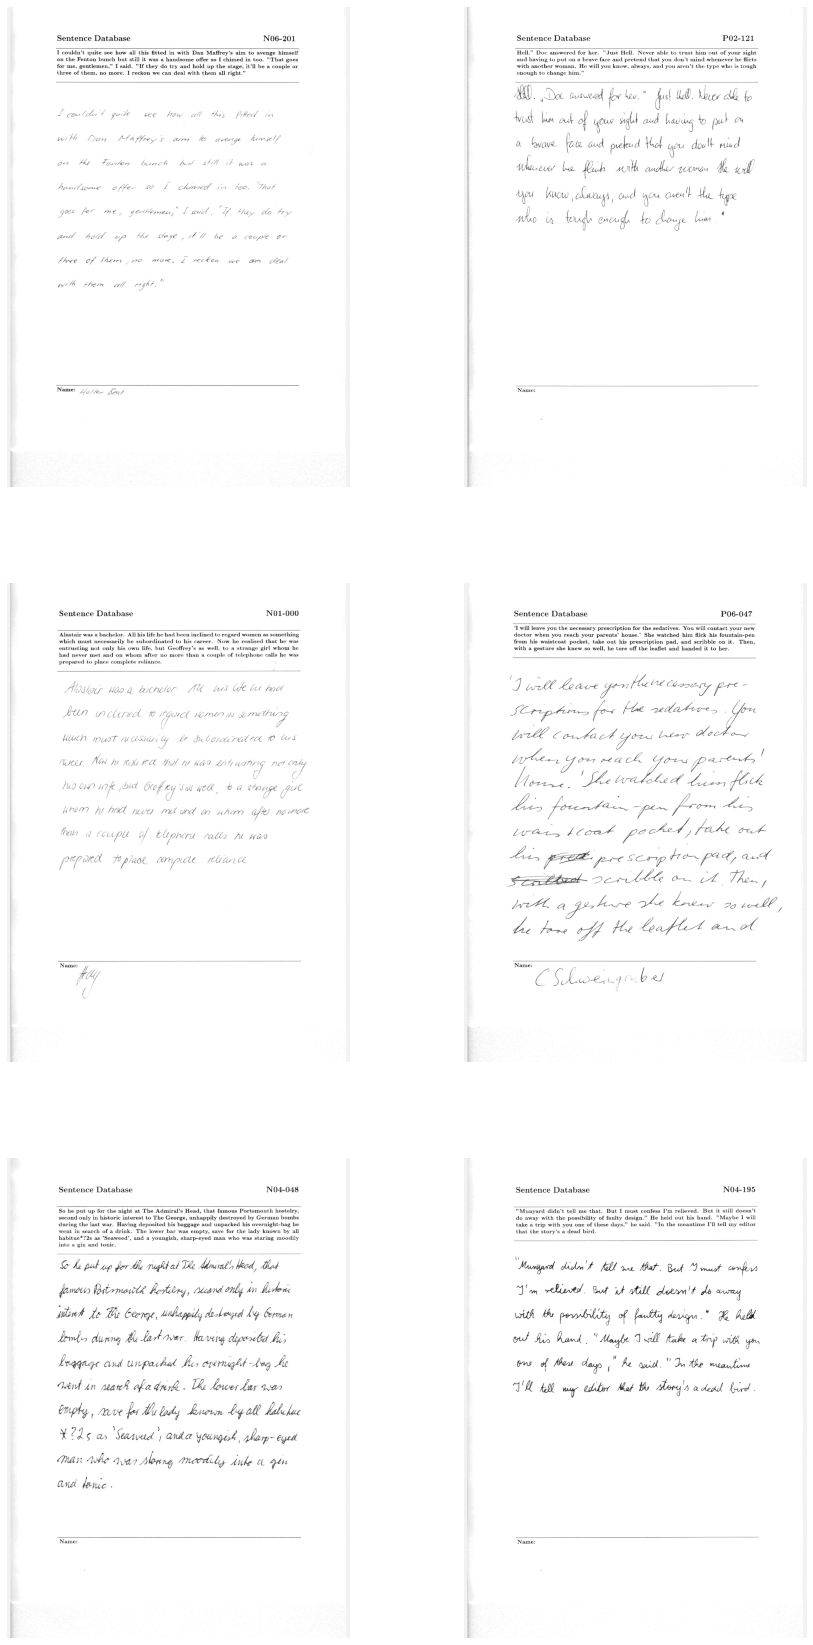

In [ ]:
fig, axs = plt.subplots(int(len(images)/2), 2, figsize=(15, 10 * len(images)/2))
for i, image in enumerate(images):
    y, x = int(i/2), int(i%2)
    axs[y, x].imshow(image, cmap='Greys_r')
    axs[y, x].axis('off')

In [ ]:
ctx = mx.gpu(0) if mx.context.num_gpus() > 0 else mx.cpu()

In [ ]:
paragraph_segmentation_net = SegmentationNetwork(ctx=ctx)
paragraph_segmentation_net.cnn.load_parameters("/content/models/paragraph_segmentation2.params", ctx=ctx)

In [ ]:
paragraph_segmentation_net.hybridize()

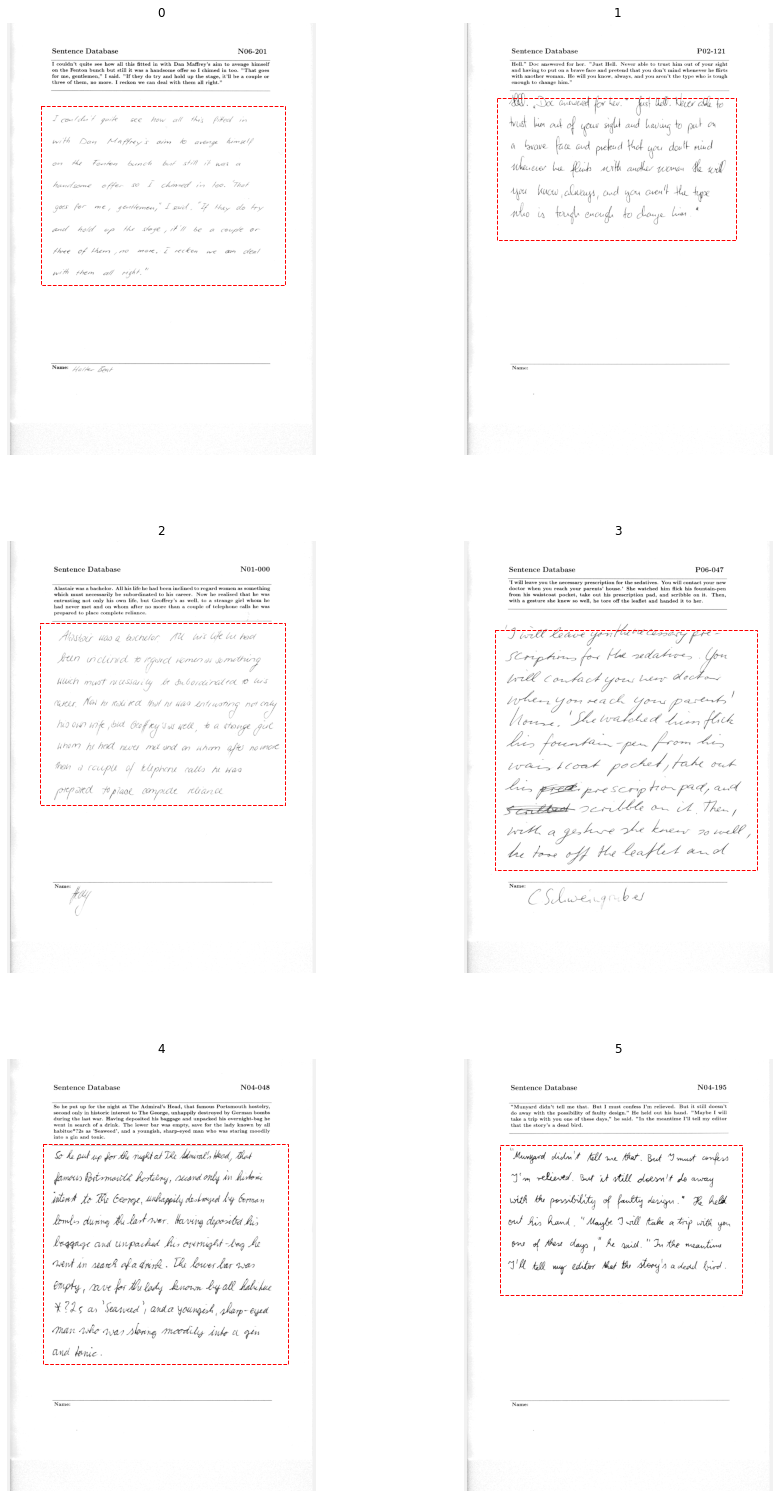

In [ ]:
form_size = (1120, 800)

predicted_bbs = []

fig, axs = plt.subplots(int(len(images)/2), 2, figsize=(15, 9 * len(images)/2))
for i, image in enumerate(images):
    s_y, s_x = int(i/2), int(i%2)
    resized_image = paragraph_segmentation_transform(image, form_size)
    bb_predicted = paragraph_segmentation_net(resized_image.as_in_context(ctx))
    bb_predicted = bb_predicted[0].asnumpy()
    bb_predicted = expand_bounding_box(bb_predicted, expand_bb_scale_x=0.03,
                                           expand_bb_scale_y=0.03)
    predicted_bbs.append(bb_predicted)
    
    axs[s_y, s_x].imshow(image, cmap='Greys_r')
    axs[s_y, s_x].set_title("{}".format(i))

    (x, y, w, h) = bb_predicted
    image_h, image_w = image.shape[-2:]
    (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
    rect = patches.Rectangle((x, y), w, h, fill=False, color="r", ls="--")
    axs[s_y, s_x].add_patch(rect)
    axs[s_y, s_x].axis('off')

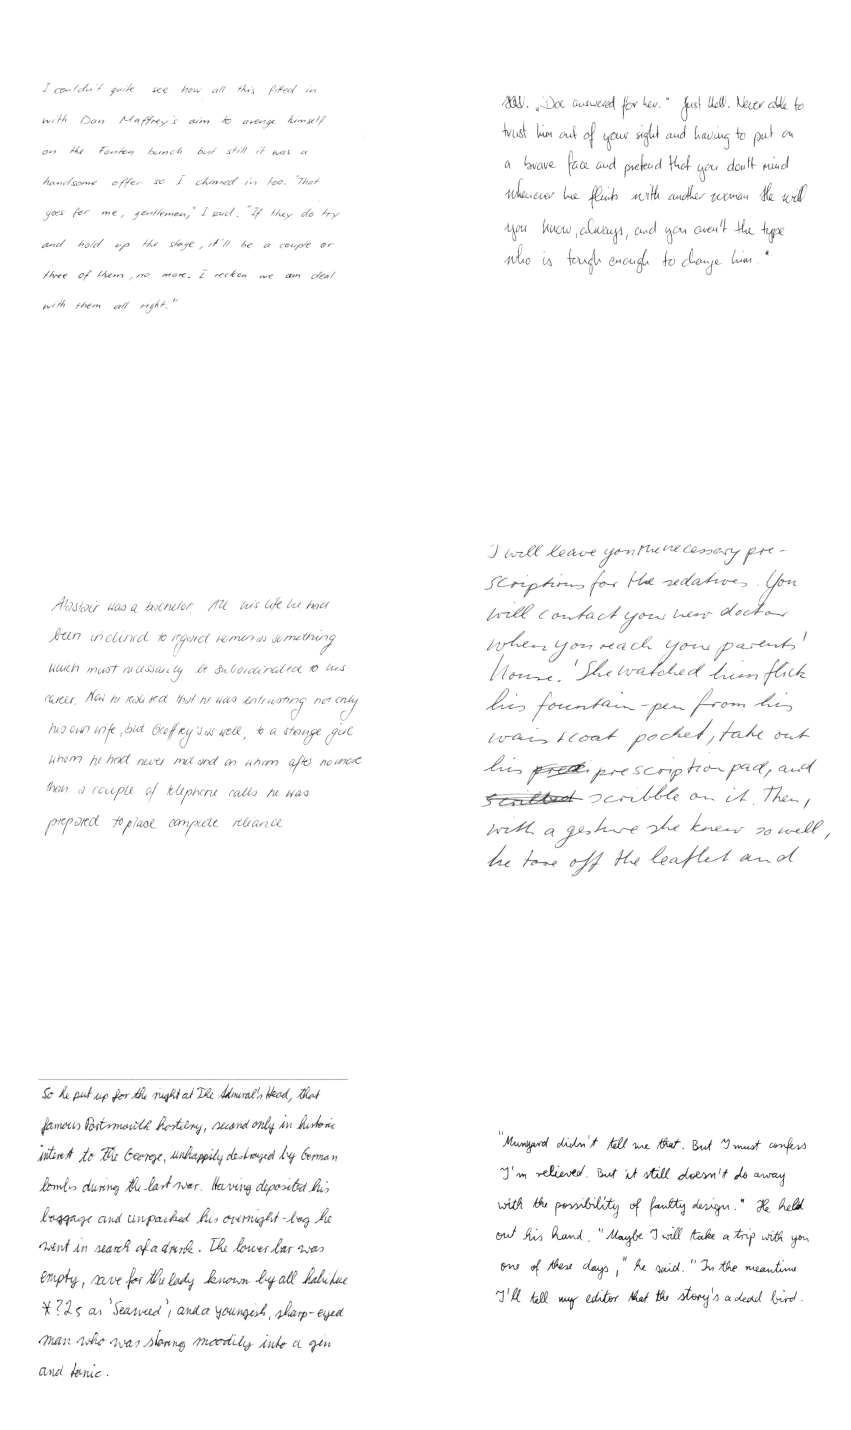

In [ ]:
segmented_paragraph_size = (700, 700)
fig, axs = plt.subplots(int(len(images)/2), 2, figsize=(15, 9 * len(images)/2))

paragraph_segmented_images = []

for i, image in enumerate(images):
    s_y, s_x = int(i/2), int(i%2)

    bb = predicted_bbs[i]
    image = crop_handwriting_page(image, bb, image_size=segmented_paragraph_size)
    paragraph_segmented_images.append(image)
    
    axs[s_y, s_x].imshow(image, cmap='Greys_r')
    axs[s_y, s_x].axis('off')

In [ ]:
word_segmentation_net = SSD(2, ctx=ctx)
word_segmentation_net.load_parameters("/content/models/word_segmentation2.params")
word_segmentation_net.hybridize()

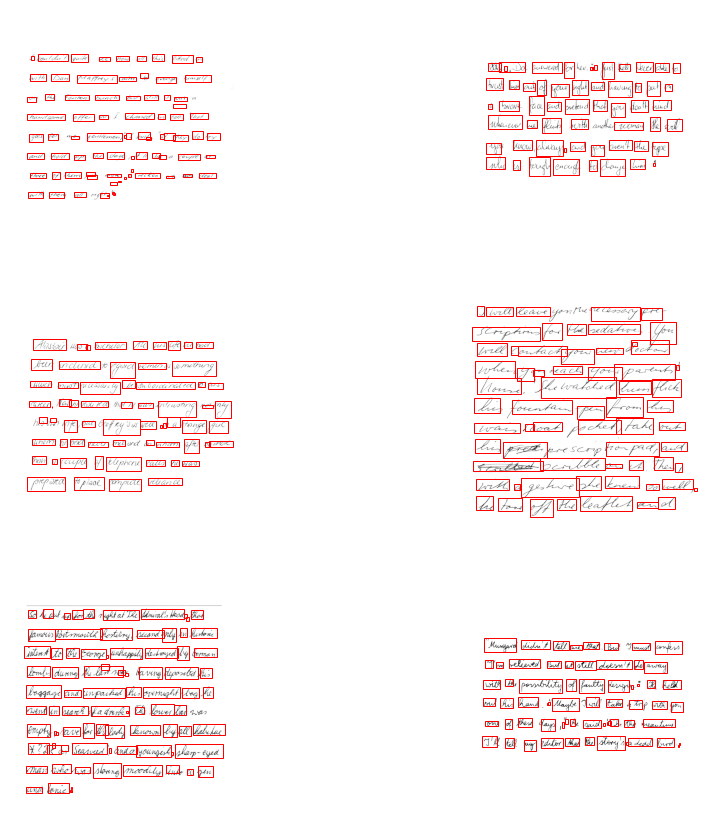

In [ ]:
min_c = 0.1
overlap_thres = 0.1
topk = 600

fig, axs = plt.subplots(int(len(paragraph_segmented_images)/2), 2, 
                        figsize=(15, 5 * int(len(paragraph_segmented_images)/2)))
predicted_words_bbs_array = []

for i, paragraph_segmented_image in enumerate(paragraph_segmented_images):
    s_y, s_x = int(i/2), int(i%2)

    predicted_bb = predict_bounding_boxes(
        word_segmentation_net, paragraph_segmented_image, min_c, overlap_thres, topk, ctx)

    predicted_words_bbs_array.append(predicted_bb)
    
    axs[s_y, s_x].imshow(paragraph_segmented_image, cmap='Greys_r')
    for j in range(predicted_bb.shape[0]):     
        (x, y, w, h) = predicted_bb[j]
        image_h, image_w = paragraph_segmented_image.shape[-2:]
        (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
        rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
        axs[s_y, s_x].add_patch(rect)
        axs[s_y, s_x].axis('off')

In [ ]:
predicted_words_bbs_array

[array([[0.33051178, 0.5274878 , 0.1464569 , 0.03327096],
        [0.29117614, 0.2836908 , 0.16456926, 0.03503937],
        [0.12638083, 0.19898456, 0.12599963, 0.02900311],
        [0.80090284, 0.6937751 , 0.0679549 , 0.02185762],
        [0.73907346, 0.28366235, 0.10877824, 0.02952009],
        [0.23870589, 0.36855206, 0.10036834, 0.02264059],
        [0.78766805, 0.21179971, 0.02324367, 0.01910901],
        [0.08563843, 0.77298874, 0.06185883, 0.02519345],
        [0.09246432, 0.2824731 , 0.06671838, 0.02719992],
        [0.68618804, 0.20321496, 0.08608687, 0.03021881],
        [0.61869615, 0.2932166 , 0.08397901, 0.02462059],
        [0.1838141 , 0.28286633, 0.07219417, 0.02807403],
        [0.17136712, 0.52996063, 0.03989357, 0.02588189],
        [0.8280734 , 0.617857  , 0.0380187 , 0.01540983],
        [0.48989305, 0.44542643, 0.12151906, 0.02535564],
        [0.18197416, 0.60996455, 0.07387955, 0.02488959],
        [0.26651254, 0.19576748, 0.07040709, 0.03726512],
        [0.710

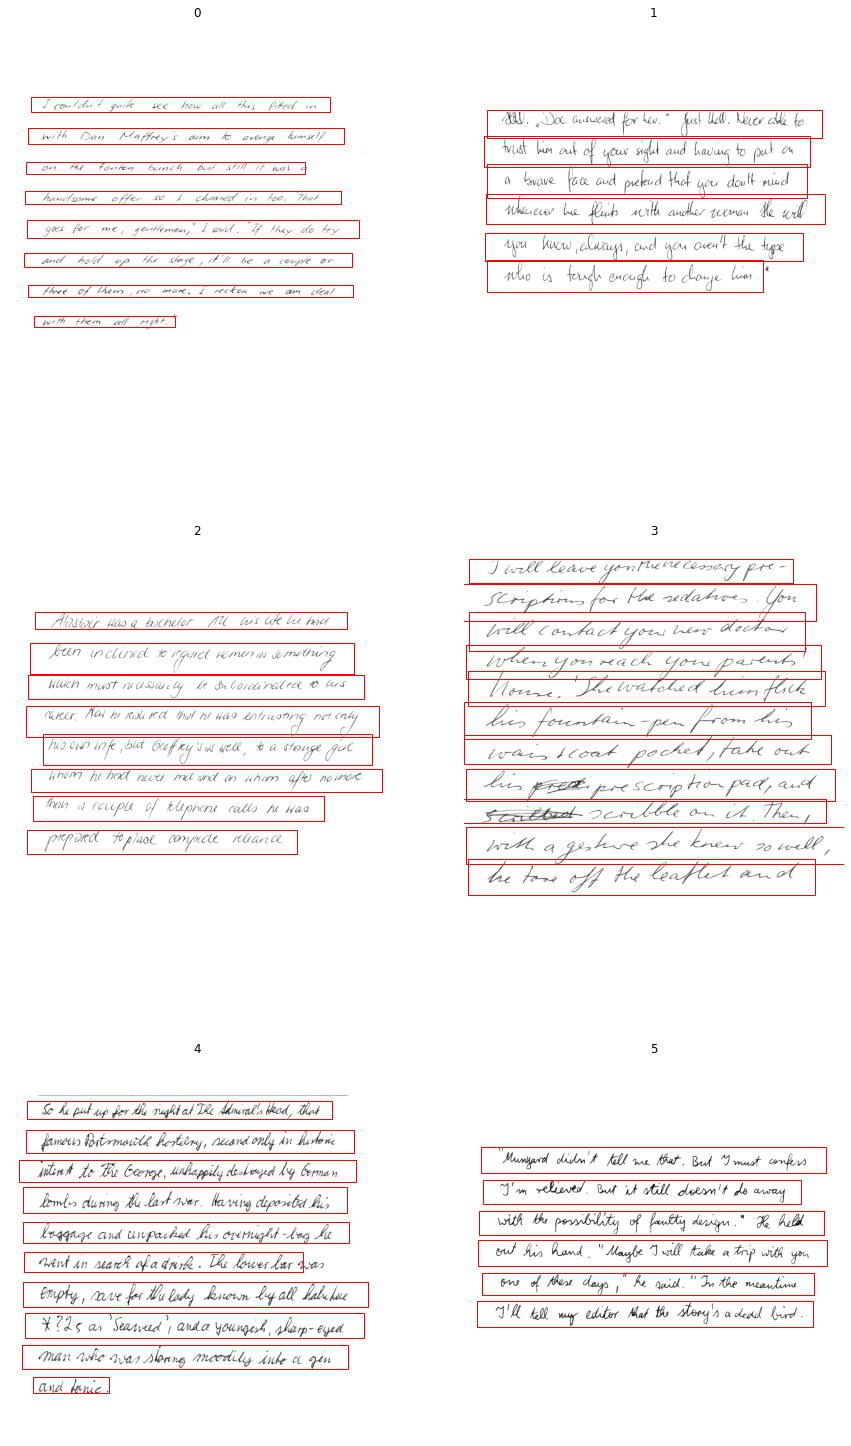

In [ ]:
line_images_array = []
fig, axs = plt.subplots(int(len(paragraph_segmented_images)/2), 2, 
                        figsize=(15, 9 * int(len(paragraph_segmented_images)/2)))

for i, paragraph_segmented_image in enumerate(paragraph_segmented_images):
    s_y, s_x = int(i/2), int(i%2)
    axs[s_y, s_x].imshow(paragraph_segmented_image, cmap='Greys_r')
    axs[s_y, s_x].axis('off')
    axs[s_y, s_x].set_title("{}".format(i))
    
    predicted_bbs = predicted_words_bbs_array[i]
    line_bbs = sort_bbs_line_by_line(predicted_bbs, y_overlap=0.4)
    line_images = crop_line_images(paragraph_segmented_image, line_bbs)
    line_images_array.append(line_images)
    
    for line_bb in line_bbs:
        (x, y, w, h) = line_bb
        image_h, image_w = paragraph_segmented_image.shape[-2:]
        (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)

        rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
        axs[s_y, s_x].add_patch(rect)

In [ ]:
handwriting_line_recognition_net = Network(rnn_hidden_states=512,
                                                             rnn_layers=2, ctx=ctx, max_seq_len=160)
handwriting_line_recognition_net.load_parameters("/content/models/handwriting_line8.params", ctx=ctx)
handwriting_line_recognition_net.hybridize()

In [ ]:
line_image_size = (60, 800)
character_probs = []
for line_images in line_images_array:
    form_character_prob = []
    for i, line_image in enumerate(line_images):
        line_image = handwriting_recognition_transform(line_image, line_image_size)
        line_character_prob = handwriting_line_recognition_net(line_image.as_in_context(ctx))
        form_character_prob.append(line_character_prob)
    character_probs.append(form_character_prob)

In [ ]:
character_probs

[[
  [[[-5.4509287  -6.23502     0.98984134 ... -3.2664907  -7.6769986
     11.991239  ]
    [-2.4506743  -5.244683   -0.6555594  ... -2.2650568  -6.0082808
     12.986011  ]
    [ 0.06627882 -4.053974   -0.06457867 ... -1.7439656  -4.886391
     13.340621  ]
    ...
    [-0.10785192 -5.35535    -2.236428   ... -2.1582184  -4.5748987
     11.651343  ]
    [-2.3954444  -5.3098927  -1.8687582  ... -1.5641863  -5.957085
     11.172068  ]
    [-3.8091745  -4.622864   -0.5160457  ... -0.7627304  -8.152293
     10.5295725 ]]]
  <NDArray 1x160x81 @cpu(0)>, 
  [[[-5.4973598  -6.918288    1.3155323  ... -3.5460346  -7.6838565
     12.185664  ]
    [-2.5612009  -5.8698125  -0.37091866 ... -2.5091233  -6.0146303
     13.210107  ]
    [-0.05028931 -4.633231    0.2521871  ... -1.9493086  -4.929104
     13.6701565 ]
    ...
    [-0.28336394 -6.2480106  -2.4693427  ... -1.3629322  -4.5513587
     13.442464  ]
    [-2.500462   -6.2132487  -2.239425   ... -0.60366106 -6.007923
     13.024825  ]
    [-3

In [ ]:
def get_arg_max(prob):
    '''
    The greedy algorithm convert the output of the handwriting recognition network
    into strings.
    '''
    arg_max = prob.topk(axis=2).asnumpy()
    return decode(arg_max)[0]

In [ ]:
def get_beam_search(prob, width=5):
    possibilities = ctcBeamSearch(prob.softmax()[0].asnumpy(), alphabet_encoding, None, width)
    return possibilities[0]

In [ ]:
FEATURE_LEN = 150
denoiser = Denoiser(alphabet_size=len(ALPHABET), max_src_length=FEATURE_LEN, max_tgt_length=FEATURE_LEN, num_heads=16, embed_size=256, num_layers=2)
denoiser.load_parameters('/content/models/denoiser2.params', ctx=ctx)

In [ ]:
denoiser.hybridize(static_alloc=True)

In [ ]:
ctx_nlp = mx.cpu(1)
language_model, vocab = nlp.model.big_rnn_lm_2048_512(dataset_name='gbw', pretrained=True,)
moses_tokenizer = nlp.data.SacreMosesTokenizer()
moses_detokenizer = nlp.data.SacreMosesDetokenizer()

Vocab file is not found. Downloading.


In [ ]:
moses_detokenizer

In [ ]:
beam_sampler = nlp.model.BeamSearchSampler(beam_size=20,
                                           decoder=denoiser.decode_logprob,
                                           eos_id=EOS,
                                           scorer=nlp.model.BeamSearchScorer(),
                                           max_length=150)

In [ ]:
generator = SequenceGenerator(beam_sampler, language_model, vocab, moses_tokenizer, moses_detokenizer)

In [ ]:
generator

In [ ]:
def get_denoised(prob, ctc_bs=False):
    if ctc_bs: # Using ctc beam search before denoising yields only limited improvements a is very slow
        text = get_beam_search(prob)
    else:
        text = get_arg_max(prob)
    src_seq, src_valid_length = encode_char(text)
    src_seq = mx.nd.array([src_seq])
    src_valid_length = mx.nd.array(src_valid_length)
    encoder_outputs, _ = denoiser.encode(src_seq, valid_length=src_valid_length)
    states = denoiser.decoder.init_state_from_encoder(encoder_outputs, 
                                                      encoder_valid_length=src_valid_length)
    inputs = mx.nd.full(shape=(1,), ctx=src_seq.context, dtype=np.float32, val=BOS)
    output = generator.generate_sequences(inputs, states, text)
    return output.strip()

In [ ]:
sentence = "This sentence has an eror"
src_seq, src_valid_length = encode_char(sentence)
src_seq = mx.nd.array([src_seq])
src_valid_length = mx.nd.array(src_valid_length)
encoder_outputs, _ = denoiser.encode(src_seq, valid_length=src_valid_length)
states = denoiser.decoder.init_state_from_encoder(encoder_outputs, 
                                                  encoder_valid_length=src_valid_length)
inputs = mx.nd.full(shape=(1,), ctx=src_seq.context, dtype=np.float32, val=BOS)
print(sentence)
print("Choice")
print(generator.generate_sequences(inputs, states, sentence))

This sentence has an eror
Choice
T h i s   s e n t e n c e  


[AM] Icouldnit quite see now all this pited in
[D ] I   c o u l d   n o t   q u i t e   s e e
[AM] with Dan Mattrey's aim to avernge himselp
[D ] w i t h   D a n   M a t r e y ' s   a i m
[AM] on the Fentors burnch but still it was a
[D ] o n   t h e   e n t e r s   b u n c h   b
[AM] handsome offer so I chimed in toe. "that
[D ] handsome offer so I chimed in toe. "that
[AM] goes for me, sentemen," I said. 'If they do try
[D ] g o e s   f o r   m e ,   g e n t l e m e n ,   "
[AM] and hold up the stage, it'in be a coupte or
[D ] a n d   h o l d   u p   t h e   s t a g e ,
[AM] three of them, no more. I reckon me can deal
[D ] three of them, no more. I reckon me can deal
[AM] with them an right:
[D ] with them an right:
[AM] HA. "Wae answered for her." Just Hell. Never able to
[D ] A .   " W e   a n s w e r e d   f o r   h e r . "   J
[AM] trust him out of your sight and having to put on
[D ] trust him out of your sight and having to put on
[AM] a brave face and pretend that you doultt 

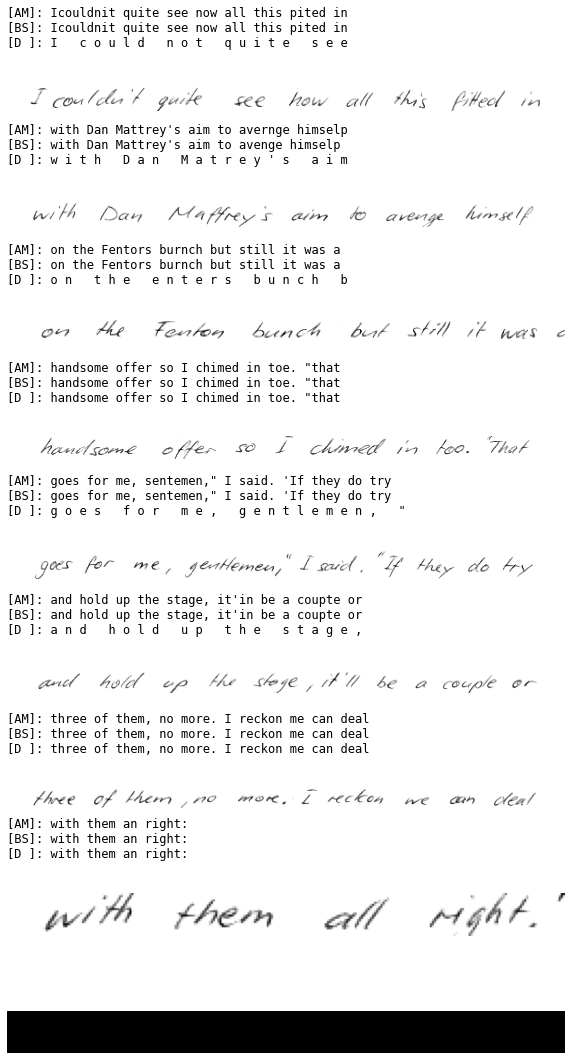

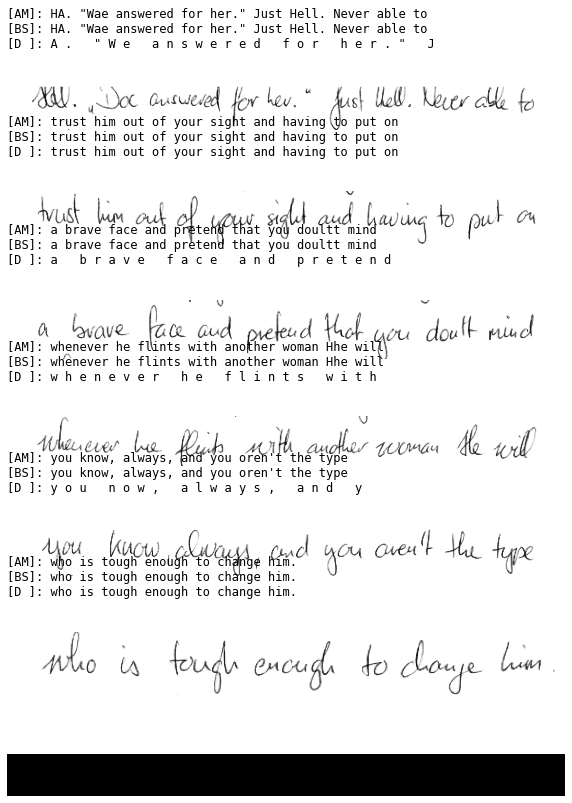

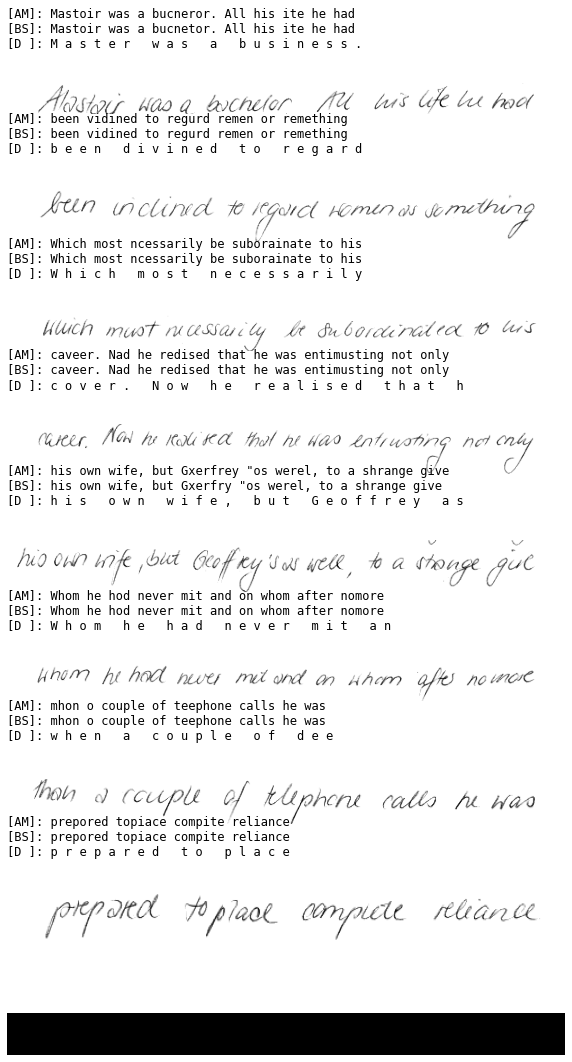

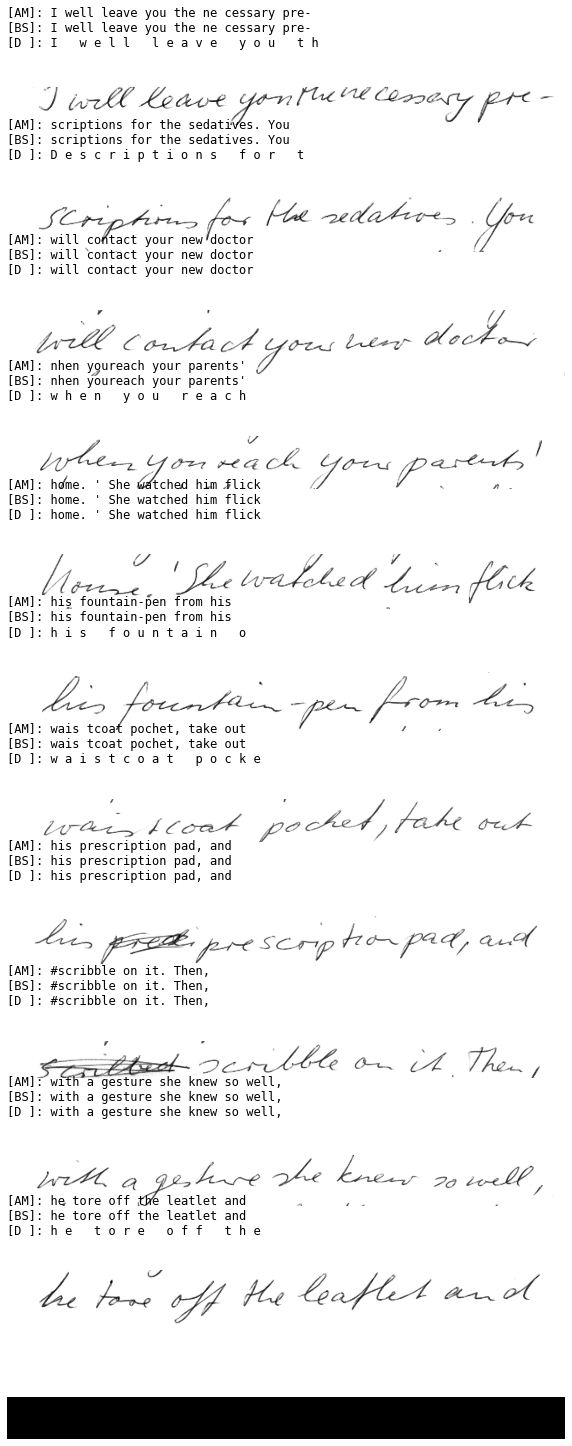

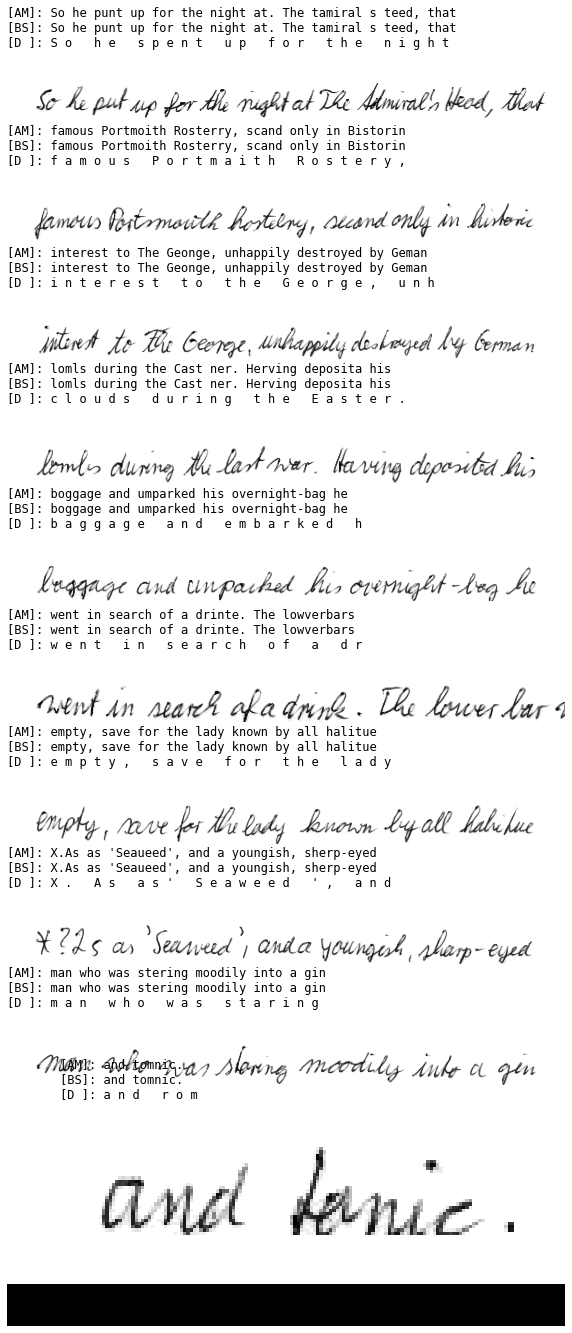

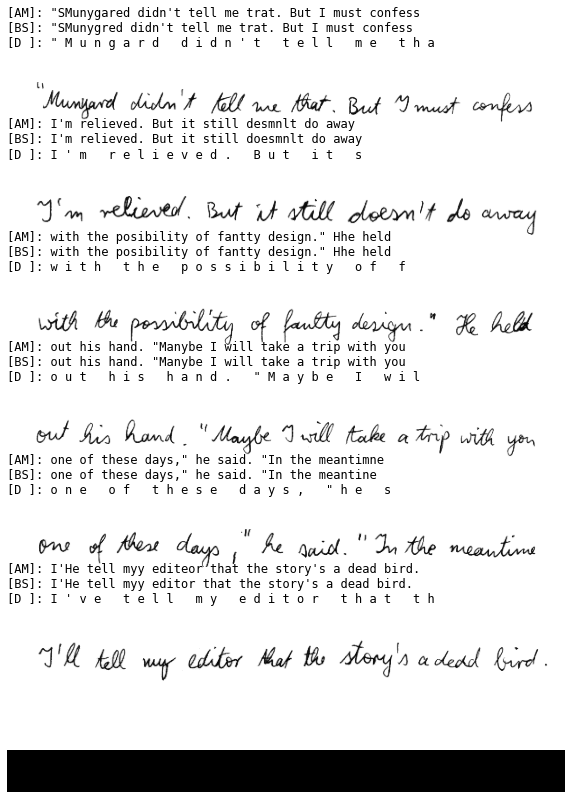

In [ ]:
for i, form_character_probs in enumerate(character_probs):
    fig, axs = plt.subplots(len(form_character_probs) + 1, 
                            figsize=(10, int(1 + 2.3 * len(form_character_probs))))
    for j, line_character_probs in enumerate(form_character_probs):
        decoded_line_am = get_arg_max(line_character_probs)
        print("[AM]",decoded_line_am)
        decoded_line_bs = get_beam_search(line_character_probs)
        decoded_line_denoiser = get_denoised(line_character_probs, ctc_bs=False)
        print("[D ]",decoded_line_denoiser)
        
        line_image = line_images_array[i][j]
        axs[j].imshow(line_image.squeeze(), cmap='Greys_r')            
        axs[j].set_title("[AM]: {}\n[BS]: {}\n[D ]: {}\n\n".format(decoded_line_am, decoded_line_bs, decoded_line_denoiser), fontdict={"horizontalalignment":"left", "family":"monospace"}, x=0)
        axs[j].axis('off')
    axs[-1].imshow(np.zeros(shape=line_image_size), cmap='Greys_r')
    axs[-1].axis('off')

In [ ]:
form_character_probs

[
 [[[-5.7079053  -6.801495    1.1410049  ... -3.207433   -7.6494985
    12.370628  ]
   [-2.7023847  -5.7246213  -0.5782461  ... -2.213552   -5.9353185
    13.291739  ]
   [-0.23926502 -4.4737453   0.01510093 ... -1.6299856  -4.7389965
    13.725603  ]
   ...
   [-0.52741593 -5.462485   -1.5745515  ... -1.5757585  -4.239527
    11.864862  ]
   [-2.1826904  -5.196562   -1.011948   ... -0.77925146 -5.3383145
    10.192388  ]
   [-2.09713    -4.387723    1.9811009  ...  0.79714423 -6.1562796
     5.5179167 ]]]
 <NDArray 1x160x81 @cpu(0)>, 
 [[[-5.666658   -7.332362    1.0276438  ... -3.1670187  -7.4765725
    11.998821  ]
   [-2.6902173  -6.204214   -0.5865849  ... -2.2055397  -5.851867
    13.054082  ]
   [-0.21055692 -4.8803344   0.09836683 ... -1.6846194  -4.7664456
    13.622054  ]
   ...
   [ 0.22718525 -3.7382097  -1.6989487  ... -3.0011625  -5.191721
    12.56884   ]
   [-2.0270274  -3.711965   -1.0958787  ... -1.9859955  -6.2629175
    11.111566  ]
   [-2.5139046  -2.7966506   1.

In [ ]:
sclite = ScliteHelper('../content/drive/My Drive/IAMDATASET')

def get_qualitative_results_lines(denoise_func):
    sclite.clear()
    test_ds_line = IAMDataset("line", train=False)
    for i in tqdm(range(1, len(test_ds_line))):
        image, text = test_ds_line[i]
        line_image = exposure.adjust_gamma(image, 1)
        line_image = handwriting_recognition_transform(line_image, line_image_size)
        character_probabilities = handwriting_line_recognition_net(line_image.as_in_context(ctx))
        decoded_text = denoise_func(character_probabilities)
        actual_text = text[0].replace("&quot;", '"').replace("&apos;","'").replace("&amp;", "&")
        sclite.add_text([decoded_text], [actual_text])
    
    cer, er = sclite.get_cer()
    print("Mean CER = {}".format(cer))
    return cer

AssertionError: ignored

In [ ]:
def get_qualitative_results(denoise_func):
    sclite.clear()
    for i in tqdm(range(1, len(test_ds))):
        image, text = test_ds[i]
        resized_image = paragraph_segmentation_transform(image, image_size=form_size)
        paragraph_bb = paragraph_segmentation_net(resized_image.as_in_context(ctx))
        paragraph_bb = paragraph_bb[0].asnumpy()
        paragraph_bb = expand_bounding_box(paragraph_bb, expand_bb_scale_x=0.01,
                                               expand_bb_scale_y=0.01)
        paragraph_segmented_image = crop_handwriting_page(image, paragraph_bb, image_size=segmented_paragraph_size)
        word_bb = predict_bounding_boxes(word_segmentation_net, paragraph_segmented_image, min_c, overlap_thres, topk, ctx)        
        line_bbs = sort_bbs_line_by_line(word_bb, y_overlap=0.4)
        line_images = crop_line_images(paragraph_segmented_image, line_bbs)

        predicted_text = []
        for line_image in line_images:
            line_image = exposure.adjust_gamma(line_image, 1)
            line_image = handwriting_recognition_transform(line_image, line_image_size)
            character_probabilities = handwriting_line_recognition_net(line_image.as_in_context(ctx))
            decoded_text = denoise_func(character_probabilities)
            predicted_text.append(decoded_text)

        actual_text = text[0].replace("&quot;", '"').replace("&apos;","'").replace("&amp;", "&")
        actual_text = actual_text.split("\n")
        if len(predicted_text) > len(actual_text):
            predicted_text = predicted_text[:len(actual_text)]
        sclite.add_text(predicted_text, actual_text)
    
    cer, _ = sclite.get_cer()
    print("Mean CER = {}".format(cer))
    return cer

In [ ]:
get_qualitative_results_lines(get_arg_max)

Completed: [----------------------------------------] 100%
Processing data:
Completed: [--------------------------------------- ]  99%

 41%|████      | 753/1859 [25:56<37:46,  2.05s/it]

In [ ]:
!df -h / | awk '{print $4}'

Avail
73G
